1. Prerequirements

In [14]:
!pip install TA-Lib
!pip install arch
!pip install pmdarima

     -------------------------------------- 843.6/843.6 kB 5.9 MB/s eta 0:00:00
     --------------------------------------- 10.4/10.4 MB 11.5 MB/s eta 0:00:00
     ---------------------------------------- 9.1/9.1 MB 11.5 MB/s eta 0:00:00
     --------------------------------------- 38.6/38.6 MB 10.9 MB/s eta 0:00:00
     ------------------------------------- 500.6/500.6 kB 10.4 MB/s eta 0:00:00
     -------------------------------------- 233.7/233.7 kB 7.0 MB/s eta 0:00:00
     -------------------------------------- 568.9/568.9 kB 7.1 MB/s eta 0:00:00
  Using cached Cython-0.29.32-py2.py3-none-any.whl (986 kB)
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
     ---------------------------------------- 7.4/7.4 MB 11.5 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 9.0 MB/s eta 0:00:00
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)


2. Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix

############### Wavelet ###############

from Wavelet import wavelet as wl

############### Feature Gen ###############

from Feature_Generation import feature_engineering as fe

############### XGBoost F_Eng ###############

import XGBoostFeatureEngineer as XFE

############### AE Dataset ###############

from AEDataset import Time_series_Dataset, create_dataset_for_autoencoder

############### Using AE ###############

from AE import AE_INDICATORS_OSCILLATORS

############### OHLCV Dataset ###############

from OHLCVDataset import create_dataset_for_ohlcv

############## Confusion Matrix #############

from Confusion_Matrix import make_confusion_matrix

3. Loading the raw dataset

In [2]:
df = pd.read_csv("C:/Users/omare/Desktop/tr/data/BTC_USDT-4h.csv")
df.drop([df.columns[0]], axis = 1, inplace = True)
df.columns = ["time", "open","high","low","close","volume"]
df.index = pd.to_datetime(df["time"], unit='ms')
df.drop(["time"],axis = 1, inplace= True)
df

,open,high,low,close,volume
time,,,,,
2017-08-17 04:00:00,4261.48,4349.99,4261.32,4349.99,82.088865
2017-08-17 08:00:00,4333.32,4485.39,4333.32,4427.30,63.619882
2017-08-17 12:00:00,4436.06,4485.39,4333.42,4352.34,174.562001
2017-08-17 16:00:00,4352.33,4354.84,4200.74,4325.23,225.109716
2017-08-17 20:00:00,4307.56,4369.69,4258.56,4285.08,249.769913
...,...,...,...,...,...
2021-02-13 16:00:00,47076.02,47400.14,46708.94,46870.15,8667.447457
2021-02-13 20:00:00,46871.95,47397.36,46653.58,47153.69,6836.242572
2021-02-14 00:00:00,47156.78,47730.00,47014.17,47267.21,10236.610927


4. Feature Generation

In [3]:
# Adding Features

add_features = fe(df)

add_features.ADX(14)  #Osc 
add_features.ATR(14)  #Osc
add_features.ATR_ratio() #Osc
add_features.BOLL() #Ind + Ind
add_features.CCI(14) #Osc
add_features.ChaikinAD() #OHLCV
add_features.EMA(14) #Ind
add_features.EMA(21) #Ind
add_features.EMA(28) #Ind
add_features.EMA(50) #Ind
add_features.GARCH() #Osc
add_features.MA(14)  #Ind
add_features.MA(21)  #Ind
add_features.MA(28)  #Ind
add_features.MA(50)  #Ind
add_features.MA_on_RSI() #Osc
add_features.MACD() #Osc + Osc + Osc
add_features.MFI(14) #Osc
add_features.MOM(14) #Osc
add_features.Parabolic_SAR() #Ind
add_features.relative() #osc
add_features.ROC(14) #osc
add_features.RSI(14) #osc
add_features.RSI_ratio() #osc
add_features.SMA(14) #Ind
add_features.SMA(21) #Ind
add_features.SMA(28) #Ind
add_features.SMA(50) #Ind
add_features.SMA_ratio() #osc
add_features.STOCHASTIC() #osc
add_features.VWMA(14) #Ind
add_features.VWMA(21) #Ind
add_features.VWMA(28) #Ind
add_features.VWMA(50) #Ind
add_features.Wilder(14) #Ind
add_features.Wilder(21) #Ind
add_features.Wilder(28) #Ind
add_features.Wilder(50) #Ind
add_features.WILLR(14) #osc
add_features.WILLR(21) #osc
add_features.WILLR(28) #osc
add_features.WILLR(50) #osc
add_features.WVAD(14) #osc
add_features.WVAD(21) #osc
add_features.WVAD(28) #osc
add_features.WVAD(50) #osc
add_features.must_be_used()
#Ind 24
#Osc 28
#OHLCV 7

5.Adding target column

In [4]:
up_down = []
values = df["close"].values


for i in range(len(df)-1):
    if(values[i] < values[i+1]):
        up_down.append(1)
    else:
        up_down.append(0)

df.drop(df.index[-1], axis = 0, inplace = True)
df["target"] = up_down
#up_down

5.Train and Test split

In [5]:
split_ratio = 0.8
split_point = int(split_ratio * len(df)) if int(split_ratio * len(df))%2==0 else int(split_ratio * len(df))+1
#train_df,test_df=[],[]
train_df = df.iloc[:split_point,:]
test_df = df.iloc[split_point:,:]
#print(train_df)

6.Applying Wavelet

In [6]:
train_df_wl, test_df_wl = wl(train_df.iloc[:,:-1], test_df.iloc[:,:-1])

In [7]:
train_df_wl['target'] = train_df['target']
test_df_wl['target'] = test_df['target']

7.Normalizing

In [8]:
scaler = MinMaxScaler()
train_df_wl_nrm = scaler.fit_transform(train_df_wl)
test_df_wl_nrm = scaler.transform(test_df_wl)

In [9]:
train_df_wl_nrm = pd.DataFrame(train_df_wl_nrm, index=train_df_wl.index, columns=train_df_wl.columns)
test_df_wl_nrm = pd.DataFrame(test_df_wl_nrm, index=test_df_wl.index, columns=test_df_wl.columns)

8.Feature Engineering by XGBoost

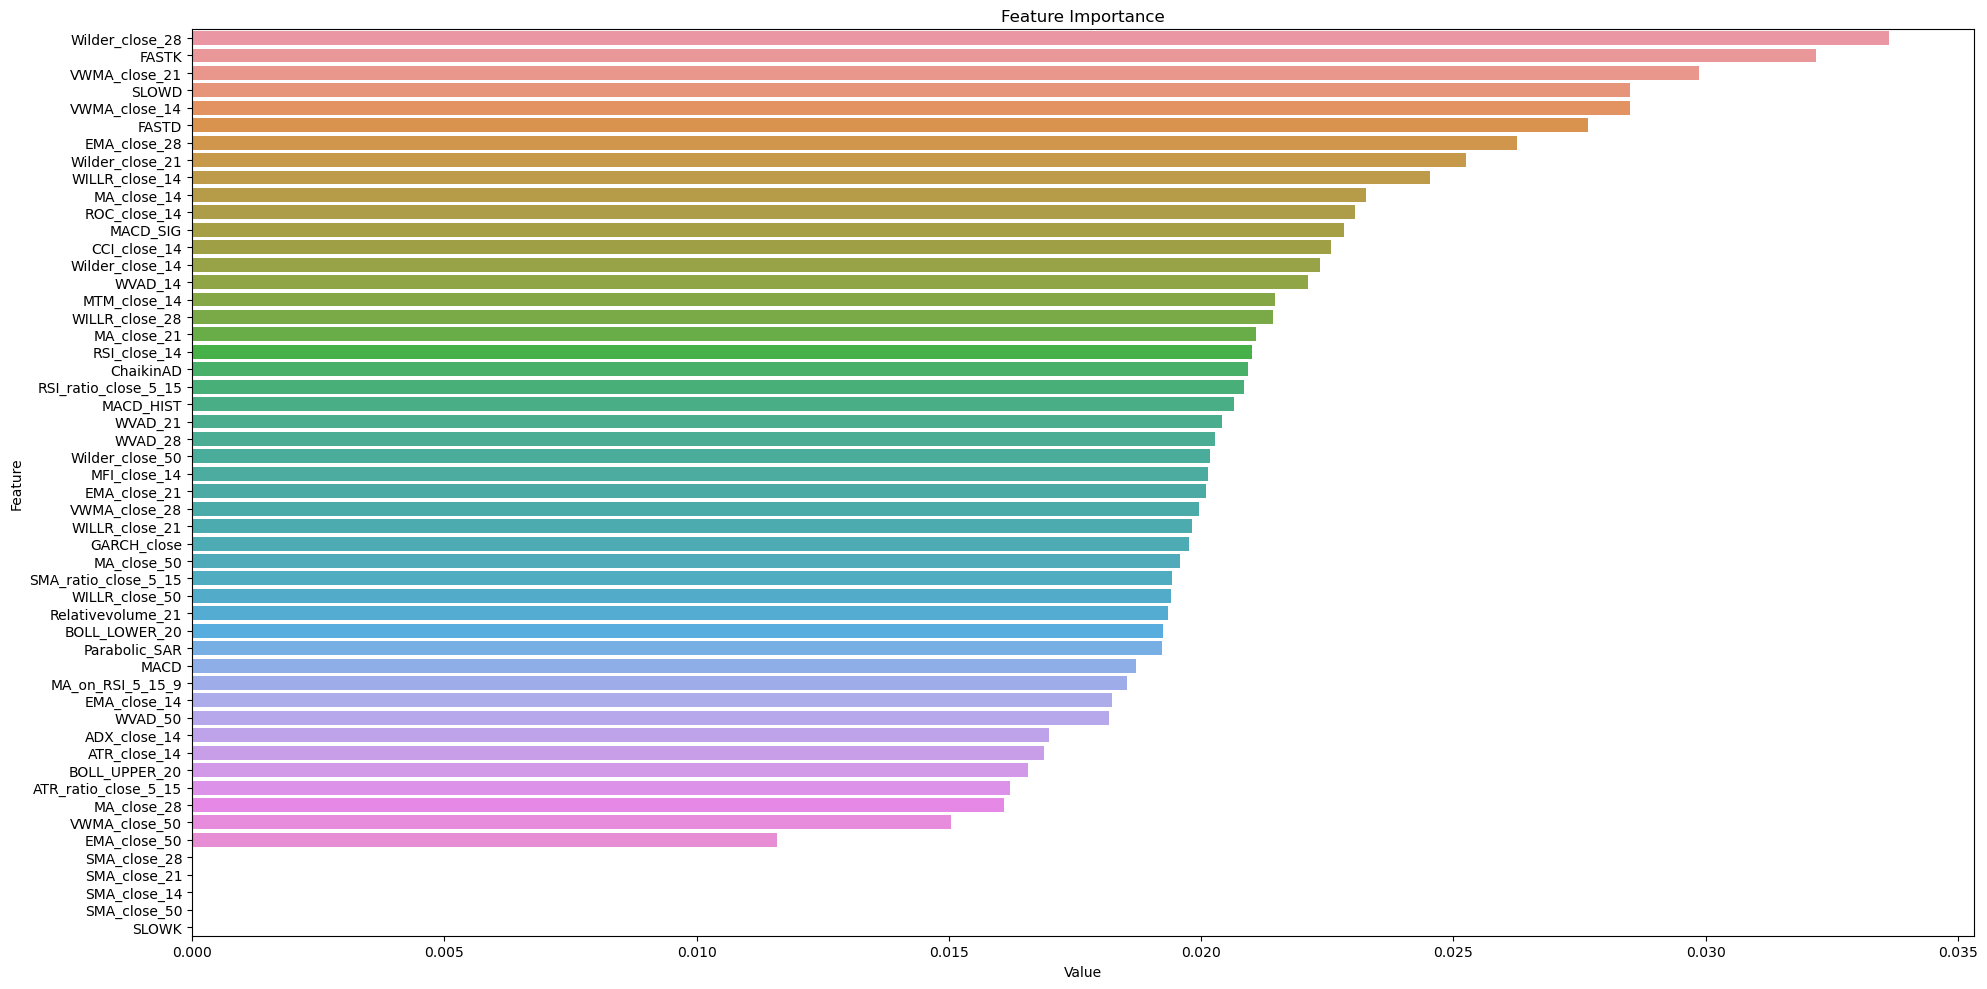

In [10]:
df_aux = train_df_wl_nrm.drop(['open', 'high', 'low', 'close', 'volume'], axis = 1)
extracted_features = XFE.feature_importance(df_aux, top = 25)

8.OHLCV, price-like indicators and none-price-like indicators



In [11]:
print(extracted_features)


['Wilder_close_28' 'FASTK' 'VWMA_close_21' 'SLOWD' 'VWMA_close_14' 'FASTD'
 'EMA_close_28' 'Wilder_close_21' 'WILLR_close_14' 'MA_close_14'
 'ROC_close_14' 'MACD_SIG' 'CCI_close_14' 'Wilder_close_14' 'WVAD_14'
 'MTM_close_14' 'WILLR_close_28' 'MA_close_21' 'RSI_close_14' 'ChaikinAD'
 'RSI_ratio_close_5_15' 'MACD_HIST' 'WVAD_21' 'WVAD_28' 'Wilder_close_50']


In [12]:
ohlcv = ['open', 'high', 'low', 'close', 'volume','ChaikinAD']

price_like_features = ['EMA_close_14','EMA_close_21','MA_close_28','MA_close_21','VWMA_close_21','Wilder_close_21','BOLL_LOWER_20','CCI_close_14']

none_price_like_features = ['WILLR_close_14','MACD_SIG','Wilder_close_28','WILLR_close_28','FASTK','MACD_HIST','MTM_close_14','MACD','FASTD','SMA_ratio_close_5_15',
                            'RSI_ratio_close_5_15','WVAD_50','SLOWD','RSI_close_14','Parabolic_SAR','ROC_close_14','MFI_close_14','GARCH_close','WVAD_14','WVAD_28']

In [13]:
len(ohlcv),len(price_like_features),len(none_price_like_features)

(6, 8, 20)

9.Split dataframe to 3 separate datasets

In [14]:
train_df_ohlcv = train_df_wl_nrm[ohlcv]
train_df_pl = train_df_wl_nrm[price_like_features]
train_df_npl = train_df_wl_nrm[none_price_like_features]

In [15]:
test_df_ohlcv = test_df_wl_nrm[ohlcv]
test_df_pl = test_df_wl_nrm[price_like_features]
test_df_npl = test_df_wl_nrm[none_price_like_features]

10.Train AE on price-like indicators


In [16]:
window_size = 24
train_size = 0.9
batch_size = 32
epochs = 200
lr = 0.0001

Training Process...
Epoch 0 Loss: 1.1370813846588135
Epoch 1 Loss: 1.088202953338623
Epoch 2 Loss: 1.0440022945404053
Epoch 3 Loss: 1.0018140077590942
Epoch 4 Loss: 0.9614976644515991
Epoch 5 Loss: 0.9228346347808838
Epoch 6 Loss: 0.8857052326202393
Epoch 7 Loss: 0.8499128818511963
Epoch 8 Loss: 0.8153377771377563
Epoch 9 Loss: 0.7818223237991333
Epoch 10 Loss: 0.7494059801101685
Epoch 11 Loss: 0.7179982662200928
Epoch 12 Loss: 0.6876012682914734
Epoch 13 Loss: 0.6582645773887634
Epoch 14 Loss: 0.6299143433570862
Epoch 15 Loss: 0.6024985313415527
Epoch 16 Loss: 0.5760054588317871
Epoch 17 Loss: 0.5503877997398376
Epoch 18 Loss: 0.5256470441818237
Epoch 19 Loss: 0.501737117767334
Epoch 20 Loss: 0.4786321520805359
Epoch 21 Loss: 0.45633062720298767
Epoch 22 Loss: 0.43481189012527466
Epoch 23 Loss: 0.4140259623527527
Epoch 24 Loss: 0.3939696252346039
Epoch 25 Loss: 0.3746260106563568
Epoch 26 Loss: 0.3559742867946625
Epoch 27 Loss: 0.3380074203014374
Epoch 28 Loss: 0.3206889033317566
Epoc

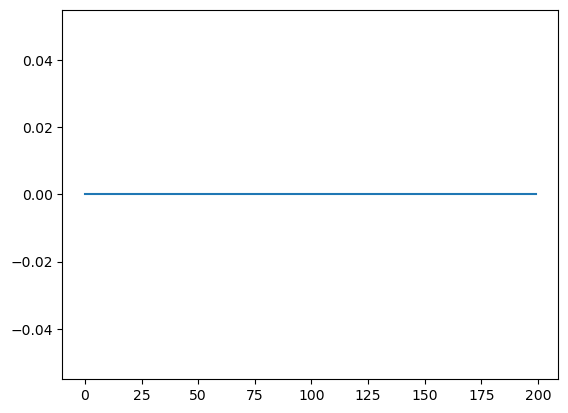


Training Process has finished
#############################
Evaluate the model...
Loss: 0.07636857312011278
Loss: 0.07762419101716628
Loss: 0.07727525042643243
Loss: 0.057483003640154545
Loss: 0.05222049424661529
Loss: 0.03782079483017011
Loss: 0.03384064880568494
Loss: 0.03710694524690917
Loss: 0.04235079996736332
Loss: 0.04113959695739155
Loss: 0.04477355146218851
Loss: 0.05275787165601892
Loss: 0.06694859387545568
Loss: 0.07465852147315782
Loss: 0.07596592080871041
Loss: 0.0727956095483364
Loss: 0.07368738292364473
Loss: 0.0743572862050793

Evaluation has finished
#############################
Visualization...


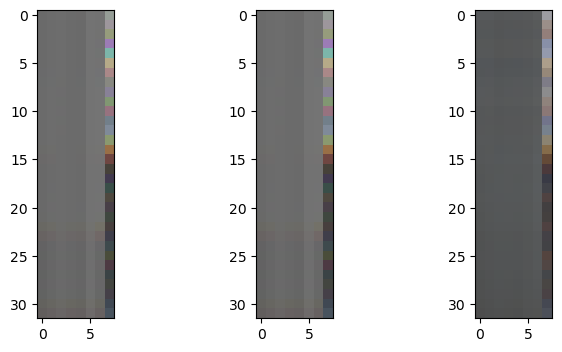

In [17]:
model, dataset = AE_INDICATORS_OSCILLATORS(train_df_pl, train_df_pl.columns, window_size, train_size, batch_size, epochs, lr,
                                           conv1_kernel_num = 9, conv1_kernel_size = 7, conv2_kernel_num = 6, conv2_kernel_size = 7,
                                           conv3_kernel_num =3, conv3_kernel_size = 7,maxpool_kernel_size = 2, max_pool_stride = 2,
                                           sanity= False)

Training Process...
Epoch 0 Loss: 1.1251544952392578
Epoch 1 Loss: 1.074320912361145
Epoch 2 Loss: 1.0257413387298584
Epoch 3 Loss: 0.979345977306366
Epoch 4 Loss: 0.9338421821594238
Epoch 5 Loss: 0.8896812200546265
Epoch 6 Loss: 0.8479042053222656
Epoch 7 Loss: 0.8082097768783569
Epoch 8 Loss: 0.770037055015564
Epoch 9 Loss: 0.7331361174583435
Epoch 10 Loss: 0.6975356340408325
Epoch 11 Loss: 0.6635262370109558
Epoch 12 Loss: 0.6311591863632202
Epoch 13 Loss: 0.6002249717712402
Epoch 14 Loss: 0.5705734491348267
Epoch 15 Loss: 0.5420951843261719
Epoch 16 Loss: 0.5146887302398682
Epoch 17 Loss: 0.48831862211227417
Epoch 18 Loss: 0.4629463851451874
Epoch 19 Loss: 0.43852323293685913
Epoch 20 Loss: 0.4150320887565613
Epoch 21 Loss: 0.39244264364242554
Epoch 22 Loss: 0.3707219064235687
Epoch 23 Loss: 0.34985947608947754
Epoch 24 Loss: 0.3298380970954895
Epoch 25 Loss: 0.3106277883052826
Epoch 26 Loss: 0.29220861196517944
Epoch 27 Loss: 0.2745437026023865
Epoch 28 Loss: 0.25762462615966797
E

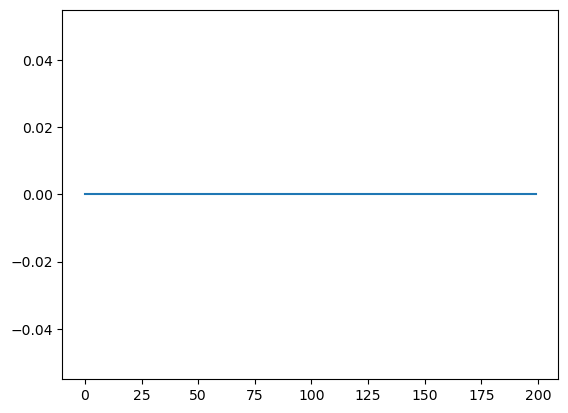


Training Process has finished
#############################


In [18]:
model, whole_dataset_train = AE_INDICATORS_OSCILLATORS(train_df_pl, train_df_pl.columns, window_size, 1.0, batch_size, epochs, lr,sanity= False)

##

In [19]:
whole_dataset_train = Time_series_Dataset(whole_dataset_train)
whole_dataloader_train_pl_AE = DataLoader(whole_dataset_train, batch_size = len(whole_dataset_train))

In [20]:
whole_dataset_test = create_dataset_for_autoencoder(test_df_pl, test_df_pl.columns, window_size)
whole_dataset_test = Time_series_Dataset(whole_dataset_test)
whole_dataloader_test_pl_AE = DataLoader(whole_dataset_test, batch_size = len(whole_dataset_test))

In [21]:
for whole_data, _ in whole_dataloader_train_pl_AE:

    whole_data = whole_data.cuda()

    whole_data = whole_data.permute(0,2,1)

    pred = model(whole_data)

    train_df_pl_AE = model.output
    train_df_pl_AE = train_df_pl_AE.permute(0,2,1)

In [22]:
for whole_data, _ in whole_dataloader_test_pl_AE:

    whole_data = whole_data.cuda()

    whole_data = whole_data.permute(0,2,1)

    pred = model(whole_data)

    test_df_pl_AE = model.output
    test_df_pl_AE = test_df_pl_AE.permute(0,2,1)

In [24]:
train_df_pl_AE.shape,test_df_pl_AE.shape

(torch.Size([6054, 24, 3]), torch.Size([1495, 24, 3]))

Train none price-like indicators


Training Process...
Epoch 0 Loss: 1.1486008167266846
Epoch 1 Loss: 1.0867913961410522
Epoch 2 Loss: 1.0391358137130737
Epoch 3 Loss: 0.9938610792160034
Epoch 4 Loss: 0.9509565234184265
Epoch 5 Loss: 0.9099475145339966
Epoch 6 Loss: 0.8705334067344666
Epoch 7 Loss: 0.8325475454330444
Epoch 8 Loss: 0.7958366274833679
Epoch 9 Loss: 0.7603757381439209
Epoch 10 Loss: 0.7261000871658325
Epoch 11 Loss: 0.6929289698600769
Epoch 12 Loss: 0.6609315872192383
Epoch 13 Loss: 0.6300684809684753
Epoch 14 Loss: 0.6002873182296753
Epoch 15 Loss: 0.5714935660362244
Epoch 16 Loss: 0.543751060962677
Epoch 17 Loss: 0.5170031189918518
Epoch 18 Loss: 0.49122655391693115
Epoch 19 Loss: 0.466405987739563
Epoch 20 Loss: 0.442538321018219
Epoch 21 Loss: 0.41958487033843994
Epoch 22 Loss: 0.3975051939487457
Epoch 23 Loss: 0.37629473209381104
Epoch 24 Loss: 0.3559052348136902
Epoch 25 Loss: 0.3363535702228546
Epoch 26 Loss: 0.3175974190235138
Epoch 27 Loss: 0.2996184825897217
Epoch 28 Loss: 0.28238800168037415
Epo

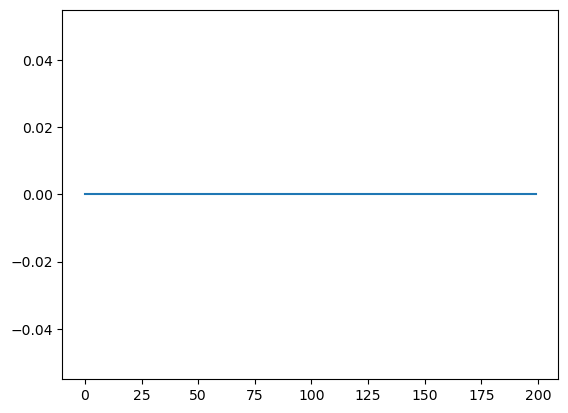


Training Process has finished
#############################
Evaluate the model...
Loss: 0.0697316376257593
Loss: 0.07159376347507132
Loss: 0.0692320636599345
Loss: 0.1483037998992992
Loss: 0.09795009274154604
Loss: 0.07535915669210484
Loss: 0.06364077089163253
Loss: 0.06024425968808303
Loss: 0.06127759277588364
Loss: 0.056171811916862366
Loss: 0.06112003908986312
Loss: 0.05598231779500809
Loss: 0.07784905277442644
Loss: 0.0669982447263063
Loss: 0.0698417661532335
Loss: 0.06339933025156962
Loss: 0.06330508030667509
Loss: 0.06845903284844362

Evaluation has finished
#############################
Visualization...


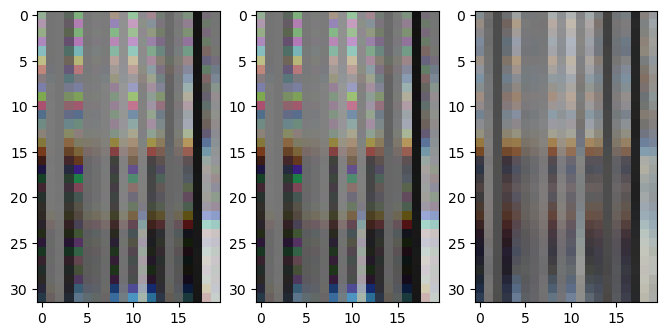

In [25]:
model, dataset = AE_INDICATORS_OSCILLATORS(train_df_npl, train_df_npl.columns, window_size, train_size, batch_size, epochs, lr,
                                           conv1_kernel_num = 9, conv1_kernel_size = 7, conv2_kernel_num = 6, conv2_kernel_size = 7,
                                           conv3_kernel_num =3, conv3_kernel_size = 7,maxpool_kernel_size = 2, max_pool_stride = 2,
                                           sanity= False)

Training Process...
Epoch 0 Loss: 1.1543970108032227
Epoch 1 Loss: 1.0918419361114502
Epoch 2 Loss: 1.0360016822814941
Epoch 3 Loss: 0.9833751916885376
Epoch 4 Loss: 0.9341109395027161
Epoch 5 Loss: 0.8878197073936462
Epoch 6 Loss: 0.8435140252113342
Epoch 7 Loss: 0.801330029964447
Epoch 8 Loss: 0.7609766125679016
Epoch 9 Loss: 0.7223142981529236
Epoch 10 Loss: 0.68517005443573
Epoch 11 Loss: 0.6494656801223755
Epoch 12 Loss: 0.6151593923568726
Epoch 13 Loss: 0.5822081565856934
Epoch 14 Loss: 0.5505256056785583
Epoch 15 Loss: 0.5201257467269897
Epoch 16 Loss: 0.49097153544425964
Epoch 17 Loss: 0.4630182385444641
Epoch 18 Loss: 0.4362720847129822
Epoch 19 Loss: 0.41067934036254883
Epoch 20 Loss: 0.38618022203445435
Epoch 21 Loss: 0.36276277899742126
Epoch 22 Loss: 0.34041598439216614
Epoch 23 Loss: 0.3190929591655731
Epoch 24 Loss: 0.29876917600631714
Epoch 25 Loss: 0.27942097187042236
Epoch 26 Loss: 0.2609984278678894
Epoch 27 Loss: 0.24348710477352142
Epoch 28 Loss: 0.2268361896276474

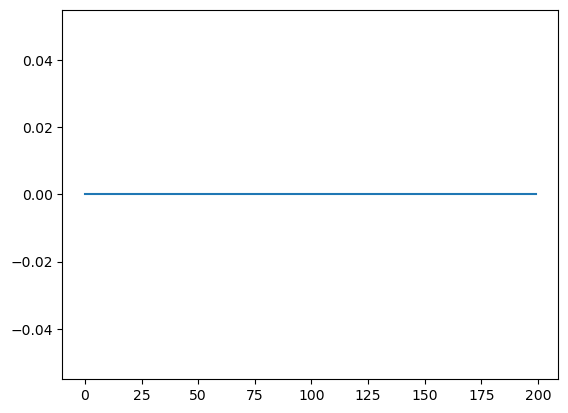


Training Process has finished
#############################


In [26]:
model, whole_dataset_train = AE_INDICATORS_OSCILLATORS(train_df_npl, train_df_npl.columns, window_size, 1.0, batch_size, epochs, lr,sanity= False)

train and test data(None price like)

In [27]:
whole_dataset_train = Time_series_Dataset(whole_dataset_train)
whole_dataloader_train_npl_AE = DataLoader(whole_dataset_train, batch_size = len(whole_dataset_train))

In [28]:
whole_dataset_test = create_dataset_for_autoencoder(test_df_npl, test_df_npl.columns, window_size)
whole_dataset_test = Time_series_Dataset(whole_dataset_test)
whole_dataloader_test_npl_AE = DataLoader(whole_dataset_test, batch_size = len(whole_dataset_test))

In [29]:
for whole_data, _ in whole_dataloader_train_npl_AE:

    whole_data = whole_data.cuda()

    whole_data = whole_data.permute(0,2,1)

    pred = model(whole_data)

    train_df_npl_AE = model.output
    train_df_npl_AE = train_df_npl_AE.permute(0,2,1)

In [30]:
for whole_data, _ in whole_dataloader_test_npl_AE:

    whole_data = whole_data.cuda()

    whole_data = whole_data.permute(0,2,1)

    pred = model(whole_data)

    test_df_npl_AE = model.output
    test_df_npl_AE = test_df_npl_AE.permute(0,2,1)

In [31]:
train_df_npl_AE.shape,test_df_npl_AE.shape

(torch.Size([6054, 24, 3]), torch.Size([1495, 24, 3]))

Create dataset for OHLCVs and define its dataloader


In [32]:
ohlcvdata = create_dataset_for_ohlcv(train_df_ohlcv, train_df_ohlcv.columns, ws = window_size)
ohlcvdataset = Time_series_Dataset(ohlcvdata)
train_df_ohlcv_dataloader_final = DataLoader(ohlcvdataset, batch_size = batch_size)

In [33]:
ohlcvdata = create_dataset_for_ohlcv(test_df_ohlcv, test_df_ohlcv.columns, ws = window_size)
ohlcvdataset = Time_series_Dataset(ohlcvdata)
test_df_ohlcv_dataloader_final = DataLoader(ohlcvdataset, batch_size = len(ohlcvdataset))

Create dataloader for Price like and None price like datasets


In [34]:
train_df_pl_AE_dataloader_final = DataLoader(train_df_pl_AE,batch_size)
train_df_npl_AE_dataloader_final = DataLoader(train_df_npl_AE,batch_size)

test_df_pl_AE_dataloader_final = DataLoader(test_df_pl_AE,len(test_df_pl_AE))
test_df_npl_AE_dataloader_final = DataLoader(test_df_npl_AE,len(test_df_npl_AE))

Checking dimensions

In [35]:
for sample1, label_sample in train_df_ohlcv_dataloader_final:
    break

for sample2 in train_df_pl_AE_dataloader_final:
    break

for sample3 in train_df_npl_AE_dataloader_final:
    break

sample1.shape, sample2.shape, sample3.shape, label_sample.shape

(torch.Size([32, 24, 6]),
 torch.Size([32, 24, 3]),
 torch.Size([32, 24, 3]),
 torch.Size([32, 1]))

In [36]:
for sample4, label_sample_ in test_df_ohlcv_dataloader_final:
    break

for sample5 in test_df_pl_AE_dataloader_final:
    break

for sample6 in test_df_npl_AE_dataloader_final:
    break

sample4.shape, sample5.shape, sample6.shape, label_sample_.shape

(torch.Size([1495, 24, 6]),
 torch.Size([1495, 24, 3]),
 torch.Size([1495, 24, 3]),
 torch.Size([1495, 1]))

Main Model Architecture

In [37]:
import torch.nn as nn
import torch.nn.functional as F
class three_line_network(nn.Module):

  def __init__(self, channel_dim_OHLCV , channel_dim_INDICATORS, channel_dim_OSCILLATORS,
               conv1_kernel_num_OHLCV , conv1_kernel_size_OHLCV, conv2_kernel_num_OHLCV, conv2_kernel_size_OHLCV,
               conv1_kernel_num_IND , conv1_kernel_size_IND, conv2_kernel_num_IND, conv2_kernel_size_IND,
               conv1_kernel_num_OSC , conv1_kernel_size_OSC, conv2_kernel_num_OSC, conv2_kernel_size_OSC,
               maxpool_kernel_size, max_pool_stride, input_size, lstm_hidden_size, lstm_num_layers, batch_size, output_size):
    

    super().__init__()

    ###OHLCV

    self.channel_dim_OHLCV = channel_dim_OHLCV
    self.conv1_kernel_num_OHLCV = conv1_kernel_num_OHLCV
    self.conv1_kernel_size_OHLCV = conv1_kernel_size_OHLCV
    self.conv2_kernel_num_OHLCV = conv2_kernel_num_OHLCV
    self.conv2_kernel_size_OHLCV = conv2_kernel_size_OHLCV

    ###INDICATORS

    self.channel_dim_INDICATORS = channel_dim_INDICATORS
    self.conv1_kernel_num_INDICATORS = conv1_kernel_num_IND
    self.conv1_kernel_size_INDICATORS = conv1_kernel_size_IND
    self.conv2_kernel_num_INDICATORS = conv2_kernel_num_IND
    self.conv2_kernel_size_INDICATORS = conv2_kernel_size_IND

    ###OSCILLATORS

    self.channel_dim_OSCILLATORS = channel_dim_OSCILLATORS
    self.conv1_kernel_num_OSCILLATORS = conv1_kernel_num_OSC
    self.conv1_kernel_size_OSCILLATORS = conv1_kernel_size_OSC
    self.conv2_kernel_num_OSCILLATORS = conv2_kernel_num_OSC
    self.conv2_kernel_size_OSCILLATORS = conv2_kernel_size_OSC

    ###LSTM

    self.input_size = input_size
    self.lstm_hidden_size = lstm_hidden_size
    self.lstm_num_layers = lstm_num_layers

    ###OTHERS

    self.maxpool_kernel_size = maxpool_kernel_size
    self.max_pool_stride = max_pool_stride
    self.batch_size = batch_size
    self.output_size = output_size



    ##################################################### CONV_OHLCV Path ####################################################

    self.conv1_OHLCV = nn.Conv1d(self.channel_dim_OHLCV, self.conv1_kernel_num_OHLCV, self.conv1_kernel_size_OHLCV, stride=1)
    self.bn1_OHLCV = nn.BatchNorm1d(self.conv1_kernel_num_OHLCV)

    self.conv2_OHLCV = nn.Conv1d(self.conv1_kernel_num_OHLCV, self.conv2_kernel_num_OHLCV, self.conv2_kernel_size_OHLCV, stride=1)
    self.bn2_OHLCV = nn.BatchNorm1d(self.conv2_kernel_num_OHLCV)

    ##################################################### CONV_INDICATORS Path #################################################

    self.conv1_IND = nn.Conv1d(self.channel_dim_INDICATORS, self.conv1_kernel_num_INDICATORS, self.conv1_kernel_size_INDICATORS, stride=1)
    self.bn1_IND = nn.BatchNorm1d(self.conv1_kernel_num_INDICATORS)

    self.conv2_IND = nn.Conv1d(self.conv1_kernel_num_INDICATORS, self.conv2_kernel_num_INDICATORS, self.conv2_kernel_size_INDICATORS, stride=1)
    self.bn2_IND = nn.BatchNorm1d(self.conv2_kernel_num_INDICATORS)   
    
    ##################################################### CONV_OSCILLATOR Path ##################################################

    self.conv1_OSC = nn.Conv1d(self.channel_dim_OSCILLATORS, self.conv1_kernel_num_OSCILLATORS, self.conv1_kernel_size_OSCILLATORS, stride=1)
    self.bn1_OSC = nn.BatchNorm1d(self.conv1_kernel_num_OSCILLATORS)

    self.conv2_OSC = nn.Conv1d(self.conv1_kernel_num_OSCILLATORS, self.conv2_kernel_num_OSCILLATORS, self.conv2_kernel_size_OSCILLATORS, stride=1)
    self.bn2_OSC = nn.BatchNorm1d(self.conv2_kernel_num_OSCILLATORS)


    self.pool = nn.MaxPool1d(kernel_size = self.maxpool_kernel_size, stride = self.max_pool_stride)

    ##################################################### LSTM ###################################################################

    self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.lstm_hidden_size, num_layers=self.lstm_num_layers, dropout=0.5)


    self.hidden = (torch.zeros(self.lstm_num_layers, self.batch_size,self.lstm_hidden_size).cuda(),
                   torch.zeros(self.lstm_num_layers, self.batch_size, self.lstm_hidden_size).cuda())
    
    
    ##################################################### FC layers ###############################################################

    self.fc1 = nn.Linear(self.lstm_hidden_size,10)
    self.fc2 = nn.Linear(10,self.output_size)
    
    


  def forward(self, OHLCV, INDS, OSCS):

    #### OHLCV

    #print(OHLCV.shape)

    X = self.bn1_OHLCV(self.conv1_OHLCV(OHLCV))
    X = F.relu(X)
    X = self.pool(X)

    #print(X.shape)

    X = self.bn2_OHLCV(self.conv2_OHLCV(X))
    X = F.relu(X)

    #print(X.shape)



    #### INDS

    #print(INDS.shape)

    Y = self.bn1_IND(self.conv1_IND(INDS))
    Y = F.relu(Y)
    Y = self.pool(Y)

    #print(Y.shape)

    Y = self.bn2_IND(self.conv2_IND(Y))
    Y = F.relu(Y)

    #print(Y.shape)



    #### OSCS

    #print(OSCS.shape)

    Z = self.bn1_OSC(self.conv1_OSC(OSCS))
    Z = F.relu(Z)
    Z = self.pool(Z)

    #print(Z.shape)

    Z = self.bn2_OSC(self.conv2_OSC(Z))
    Z = F.relu(Z)

    #print(Z.shape)  

    convs_output = torch.cat((X,Y,Z), dim=1) 
    

    #print(convs_output.shape)

    '''

    input_size = The number of features of input sequence



    input & (h_0,c_0) -> lstm unit

    input   :  (seq_len, batch, input_size)
    h_0,c_0 :  (num_layers * num_directions, batch, hidden_size)



    lstm unit -> output & (h_n, c_n)

    output  :  (seq_len, batch, num_directions * hidden_size)
    h_n,c_n :  (num_layers * num_directions, batch, hidden_size)

    '''

    lstm_out, self.hidden = self.lstm(convs_output.permute(2,0,1), self.hidden)



    fc = F.relu(self.fc1(lstm_out[-1,:,:]))
    #print(fc.shape)
    fc = self.fc2(fc)
    #print(fc.shape)

    return F.sigmoid(fc)
    

Sanity Check

In [38]:
batch_size = 32
epochs = 450
lr = 0.0001

In [39]:
torch.cuda.is_available()

True

In [40]:
model = three_line_network(channel_dim_OHLCV=sample1.shape[-1],channel_dim_INDICATORS=sample2.shape[-1],channel_dim_OSCILLATORS=sample3.shape[-1],
                           conv1_kernel_num_OHLCV=sample1.shape[-1],conv1_kernel_size_OHLCV=5,conv2_kernel_num_OHLCV=sample1.shape[-1],conv2_kernel_size_OHLCV=3,
                           conv1_kernel_num_IND=sample2.shape[-1],conv1_kernel_size_IND=5,conv2_kernel_num_IND=sample2.shape[-1],conv2_kernel_size_IND=3,
                           conv1_kernel_num_OSC=sample3.shape[-1],conv1_kernel_size_OSC=5,conv2_kernel_num_OSC=sample3.shape[-1],conv2_kernel_size_OSC=3,
                           maxpool_kernel_size=2, max_pool_stride=2, input_size=12, lstm_hidden_size=20, lstm_num_layers=1, batch_size=batch_size, output_size=1)


In [41]:
model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [42]:
sample1_=sample1.permute(0,2,1)
sample2_=sample2.permute(0,2,1)
sample3_=sample3.permute(0,2,1)

In [43]:
for iter in range(4000):

    model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
          (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))
    out = model(sample1_,sample2_.detach(),sample3_.detach())
    loss = criterion(out, label_sample)
    print(f'Loss: {loss}')

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

Loss: 0.6936428546905518
Loss: 0.6935762166976929
Loss: 0.6935096979141235
Loss: 0.6934434175491333
Loss: 0.6933784484863281
Loss: 0.6933144330978394
Loss: 0.6932505369186401
Loss: 0.6931882500648499
Loss: 0.6931279897689819
Loss: 0.6930674314498901
Loss: 0.6930068731307983
Loss: 0.6929458379745483
Loss: 0.6928836107254028
Loss: 0.6928215026855469
Loss: 0.6927593946456909
Loss: 0.6926978826522827
Loss: 0.6926373839378357
Loss: 0.6925770044326782
Loss: 0.692517101764679
Loss: 0.692457914352417
Loss: 0.6924002170562744
Loss: 0.6923429369926453
Loss: 0.6922858953475952
Loss: 0.6922308206558228
Loss: 0.6921783685684204
Loss: 0.6921259164810181
Loss: 0.6920731067657471
Loss: 0.6920205354690552
Loss: 0.6919687986373901
Loss: 0.6919171214103699
Loss: 0.6918654441833496
Loss: 0.6918144226074219
Loss: 0.6917646527290344
Loss: 0.6917145848274231
Loss: 0.6916643381118774
Loss: 0.6916136741638184
Loss: 0.6915620565414429
Loss: 0.6915099620819092
Loss: 0.6914569139480591
Loss: 0.691402792930603
Los

Loss: 0.6235615015029907
Loss: 0.6228649616241455
Loss: 0.6221493482589722
Loss: 0.6214518547058105
Loss: 0.6207466125488281
Loss: 0.6200243234634399
Loss: 0.6192995309829712
Loss: 0.6185678243637085
Loss: 0.6178258657455444
Loss: 0.617095947265625
Loss: 0.6163558959960938
Loss: 0.6156295537948608
Loss: 0.6148847937583923
Loss: 0.6141220331192017
Loss: 0.6133800745010376
Loss: 0.6126104593276978
Loss: 0.6118453741073608
Loss: 0.6110714077949524
Loss: 0.6102926135063171
Loss: 0.609525203704834
Loss: 0.6087486743927002
Loss: 0.6079599261283875
Loss: 0.6071648597717285
Loss: 0.6063903570175171
Loss: 0.6056089401245117
Loss: 0.6048276424407959
Loss: 0.6040393114089966
Loss: 0.6032484769821167
Loss: 0.6024596095085144
Loss: 0.6016569137573242
Loss: 0.6008673906326294
Loss: 0.6000546813011169
Loss: 0.5992565751075745
Loss: 0.5984528064727783
Loss: 0.5976336598396301
Loss: 0.5968136787414551
Loss: 0.5959886312484741
Loss: 0.5951611995697021
Loss: 0.5943307876586914
Loss: 0.5934924483299255
Lo

Loss: 0.28337356448173523
Loss: 0.28245091438293457
Loss: 0.2815753221511841
Loss: 0.28061938285827637
Loss: 0.27970388531684875
Loss: 0.27877864241600037
Loss: 0.2778910994529724
Loss: 0.2769813537597656
Loss: 0.27604377269744873
Loss: 0.2752002477645874
Loss: 0.2742158770561218
Loss: 0.2733515799045563
Loss: 0.27239713072776794
Loss: 0.27150434255599976
Loss: 0.2705843150615692
Loss: 0.2697174847126007
Loss: 0.2687038779258728
Loss: 0.2677907943725586
Loss: 0.26692697405815125
Loss: 0.26597917079925537
Loss: 0.2650492191314697
Loss: 0.26415592432022095
Loss: 0.263211727142334
Loss: 0.2622913122177124
Loss: 0.26144763827323914
Loss: 0.26052039861679077
Loss: 0.2596254050731659
Loss: 0.25869637727737427
Loss: 0.25786828994750977
Loss: 0.25686395168304443
Loss: 0.2560296654701233
Loss: 0.255117803812027
Loss: 0.2541258633136749
Loss: 0.2531983554363251
Loss: 0.2523733377456665
Loss: 0.2515028715133667
Loss: 0.2505517899990082
Loss: 0.24961809813976288
Loss: 0.24869468808174133
Loss: 0.2

Loss: 0.06815285235643387
Loss: 0.06788831204175949
Loss: 0.0676252469420433
Loss: 0.06736413389444351
Loss: 0.06710552424192429
Loss: 0.06684766709804535
Loss: 0.06659089028835297
Loss: 0.06633584201335907
Loss: 0.06608198583126068
Loss: 0.0658290833234787
Loss: 0.06557650119066238
Loss: 0.06532296538352966
Loss: 0.06507033854722977
Loss: 0.06481669843196869
Loss: 0.06456384062767029
Loss: 0.0643112063407898
Loss: 0.06406059861183167
Loss: 0.0638105496764183
Loss: 0.06356072425842285
Loss: 0.06331291794776917
Loss: 0.063067227602005
Loss: 0.0628233477473259
Loss: 0.06258033215999603
Loss: 0.06233780086040497
Loss: 0.062097176909446716
Loss: 0.061857499182224274
Loss: 0.0616191029548645
Loss: 0.06138184666633606
Loss: 0.06114592403173447
Loss: 0.06091271713376045
Loss: 0.06068135052919388
Loss: 0.060457028448581696
Loss: 0.060233667492866516
Loss: 0.06001211702823639
Loss: 0.059791240841150284
Loss: 0.05957207828760147
Loss: 0.05935428664088249
Loss: 0.05913664400577545
Loss: 0.0589201

Loss: 0.025100499391555786
Loss: 0.025039441883563995
Loss: 0.02497853897511959
Loss: 0.02491772174835205
Loss: 0.024857264012098312
Loss: 0.024797003716230392
Loss: 0.024737000465393066
Loss: 0.024677973240613937
Loss: 0.024617396295070648
Loss: 0.024558817967772484
Loss: 0.024499692022800446
Loss: 0.02444026619195938
Loss: 0.024381842464208603
Loss: 0.024322576820850372
Loss: 0.024264026433229446
Loss: 0.024206066504120827
Loss: 0.024147585034370422
Loss: 0.024089597165584564
Loss: 0.024032339453697205
Loss: 0.02397526055574417
Loss: 0.023918136954307556
Loss: 0.023860689252614975
Loss: 0.02380369044840336
Loss: 0.023746073246002197
Loss: 0.023690033704042435
Loss: 0.023634381592273712
Loss: 0.023577718064188957
Loss: 0.0235213004052639
Loss: 0.02346544712781906
Loss: 0.023410383611917496
Loss: 0.02335473522543907
Loss: 0.023299437016248703
Loss: 0.023243777453899384
Loss: 0.02318883128464222
Loss: 0.02313428744673729
Loss: 0.02307974547147751
Loss: 0.02302531525492668
Loss: 0.022971

Loss: 0.012499252334237099
Loss: 0.012475037015974522
Loss: 0.012450920417904854
Loss: 0.012426663190126419
Loss: 0.012402672320604324
Loss: 0.012378811836242676
Loss: 0.012354951351881027
Loss: 0.01233132928609848
Loss: 0.01230728067457676
Loss: 0.01228373870253563
Loss: 0.012260330840945244
Loss: 0.012236750684678555
Loss: 0.012213089503347874
Loss: 0.012189623899757862
Loss: 0.012166082859039307
Loss: 0.01214263029396534
Loss: 0.012119229882955551
Loss: 0.01209624856710434
Loss: 0.012073194608092308
Loss: 0.012050041928887367
Loss: 0.012027064338326454
Loss: 0.01200397964566946
Loss: 0.011980798095464706
Loss: 0.011958003975450993
Loss: 0.01193526852875948
Loss: 0.011912424117326736
Loss: 0.011889707297086716
Loss: 0.011867182329297066
Loss: 0.011844653636217117
Loss: 0.011821920052170753
Loss: 0.011799570173025131
Loss: 0.01177707314491272
Loss: 0.011754733510315418
Loss: 0.011732460930943489
Loss: 0.01171032339334488
Loss: 0.011688176542520523
Loss: 0.011665825732052326
Loss: 0.01

Loss: 0.0073960917070508
Loss: 0.007385348901152611
Loss: 0.007374635897576809
Loss: 0.007364053279161453
Loss: 0.007353441324084997
Loss: 0.007342883851379156
Loss: 0.007332324981689453
Loss: 0.007321744225919247
Loss: 0.00731115834787488
Loss: 0.007300767116248608
Loss: 0.00729035260155797
Loss: 0.007279840297996998
Loss: 0.007269356399774551
Loss: 0.007259076461195946
Loss: 0.007248826790601015
Loss: 0.007238530088216066
Loss: 0.007228162605315447
Loss: 0.007217790000140667
Loss: 0.007207444868981838
Loss: 0.007197239901870489
Loss: 0.007186973001807928
Loss: 0.007176675833761692
Loss: 0.007166522089391947
Loss: 0.007156347390264273
Loss: 0.0071462783962488174
Loss: 0.00713615957647562
Loss: 0.007125977426767349
Loss: 0.007115984335541725
Loss: 0.007105931639671326
Loss: 0.007095931097865105
Loss: 0.007085827179253101
Loss: 0.007075867149978876
Loss: 0.007065934129059315
Loss: 0.0070559801533818245
Loss: 0.007045973092317581
Loss: 0.007036164402961731
Loss: 0.007026322185993195
Loss

Loss: 0.004936135374009609
Loss: 0.004930280614644289
Loss: 0.004924491047859192
Loss: 0.004918679594993591
Loss: 0.004912871867418289
Loss: 0.004907058551907539
Loss: 0.004901296459138393
Loss: 0.004895518068224192
Loss: 0.004889746196568012
Loss: 0.004884019494056702
Loss: 0.00487826531752944
Loss: 0.00487251952290535
Loss: 0.004866825416684151
Loss: 0.004861094988882542
Loss: 0.0048554143868386745
Loss: 0.004849706776440144
Loss: 0.004844045266509056
Loss: 0.0048383865505456924
Loss: 0.004832732491195202
Loss: 0.00482707004994154
Loss: 0.004821427632123232
Loss: 0.004815784282982349
Loss: 0.004810166545212269
Loss: 0.004804573953151703
Loss: 0.004798941779881716
Loss: 0.004793361760675907
Loss: 0.0047877938486635685
Loss: 0.004782212898135185
Loss: 0.004776611924171448
Loss: 0.004771087318658829
Loss: 0.004765565972775221
Loss: 0.004760013427585363
Loss: 0.004754452034831047
Loss: 0.004748938139528036
Loss: 0.004743434488773346
Loss: 0.004737932235002518
Loss: 0.0047324239276349545


Loss: 0.0035240198485553265
Loss: 0.0035203960724174976
Loss: 0.003516796976327896
Loss: 0.003513192292302847
Loss: 0.0035095964558422565
Loss: 0.0035059938672930002
Loss: 0.0035024210810661316
Loss: 0.003498836886137724
Loss: 0.0034952713176608086
Loss: 0.0034916980657726526
Loss: 0.0034881308674812317
Loss: 0.003484552726149559
Loss: 0.0034810160286724567
Loss: 0.0034774583764374256
Loss: 0.0034739153925329447
Loss: 0.003470360767096281
Loss: 0.0034668194130063057
Loss: 0.0034633027389645576
Loss: 0.0034597693011164665
Loss: 0.003456238191574812
Loss: 0.003452735021710396
Loss: 0.0034492183476686478
Loss: 0.0034457112196832895
Loss: 0.0034421945456415415
Loss: 0.003438706509768963
Loss: 0.003435214515775442
Loss: 0.0034317239187657833
Loss: 0.003428246360272169
Loss: 0.0034247729927301407
Loss: 0.0034212868195027113
Loss: 0.003417830914258957
Loss: 0.0034143743105232716
Loss: 0.0034109067637473345
Loss: 0.0034074466675519943
Loss: 0.0034039895981550217
Loss: 0.003400559304282069
Loss

Loss: 0.002594927791506052
Loss: 0.0025925408117473125
Loss: 0.002590142423287034
Loss: 0.0025877587031573057
Loss: 0.0025853808037936687
Loss: 0.002583014080300927
Loss: 0.0025806212797760963
Loss: 0.0025782680604606867
Loss: 0.002575875259935856
Loss: 0.0025735164526849985
Loss: 0.0025711555499583483
Loss: 0.0025687762536108494
Loss: 0.002566422801464796
Loss: 0.0025640656240284443
Loss: 0.0025617252103984356
Loss: 0.002559368032962084
Loss: 0.002557035069912672
Loss: 0.0025546851102262735
Loss: 0.0025523523800075054
Loss: 0.0025500026531517506
Loss: 0.002547673648223281
Loss: 0.002545327879488468
Loss: 0.0025430121459066868
Loss: 0.00254067569039762
Loss: 0.0025383559986948967
Loss: 0.00253602908924222
Loss: 0.002533725695684552
Loss: 0.0025314022786915302
Loss: 0.002529101213440299
Loss: 0.002526791300624609
Loss: 0.002524482784792781
Loss: 0.0025221763644367456
Loss: 0.002519866218790412
Loss: 0.0025175728369504213
Loss: 0.00251527177169919
Loss: 0.0025129858404397964
Loss: 0.0025

Loss: 0.0019929353147745132
Loss: 0.0019912542775273323
Loss: 0.0019895602017641068
Loss: 0.0019878679886460304
Loss: 0.001986175775527954
Loss: 0.0019845040515065193
Loss: 0.0019828251097351313
Loss: 0.001981130801141262
Loss: 0.0019794648978859186
Loss: 0.0019777840934693813
Loss: 0.001976099330931902
Loss: 0.0019744313322007656
Loss: 0.0019727691542357206
Loss: 0.001971099292859435
Loss: 0.001969427801668644
Loss: 0.0019677672535181046
Loss: 0.001966106938198209
Loss: 0.001964439172297716
Loss: 0.0019627693109214306
Loss: 0.001961120404303074
Loss: 0.001959456130862236
Loss: 0.0019578086212277412
Loss: 0.0019561578519642353
Loss: 0.0019545031245797873
Loss: 0.0019528537523001432
Loss: 0.001951206591911614
Loss: 0.0019495649030432105
Loss: 0.0019479193724691868
Loss: 0.0019462795462459326
Loss: 0.0019446546211838722
Loss: 0.0019429998937994242
Loss: 0.0019413658883422613
Loss: 0.0019397224532440305
Loss: 0.001938104978762567
Loss: 0.001936467131599784
Loss: 0.0019348422065377235
Loss

Loss: 0.001562862191349268
Loss: 0.0015616321470588446
Loss: 0.0015603796346113086
Loss: 0.0015591420233249664
Loss: 0.0015579082537442446
Loss: 0.001556668896228075
Loss: 0.001555431168526411
Loss: 0.0015542084584012628
Loss: 0.0015529689844697714
Loss: 0.0015517408028244972
Loss: 0.0015505013288930058
Loss: 0.0015492712846025825
Loss: 0.0015480449656024575
Loss: 0.0015468166675418615
Loss: 0.0015455996617674828
Loss: 0.0015443714801222086
Loss: 0.001543146907351911
Loss: 0.0015419204719364643
Loss: 0.0015407034661620855
Loss: 0.0015394939109683037
Loss: 0.0015382657293230295
Loss: 0.0015370412729680538
Loss: 0.0015358279924839735
Loss: 0.0015346052823588252
Loss: 0.0015334069030359387
Loss: 0.0015321787213906646
Loss: 0.0015309767331928015
Loss: 0.0015297634527087212
Loss: 0.0015285538975149393
Loss: 0.0015273499302566051
Loss: 0.0015261422377079725
Loss: 0.0015249383868649602
Loss: 0.001523732440546155
Loss: 0.0015225287061184645
Loss: 0.0015213227597996593
Loss: 0.00152012635953724

Loss: 0.001220019767060876
Loss: 0.0012191091664135456
Loss: 0.0012181894853711128
Loss: 0.0012172788847237825
Loss: 0.0012163701467216015
Loss: 0.0012154597789049149
Loss: 0.0012145380023866892
Loss: 0.0012136275181546807
Loss: 0.0012127301888540387
Loss: 0.0012118197046220303
Loss: 0.0012109072413295507
Loss: 0.0012099931482225657
Loss: 0.0012091011740267277
Loss: 0.0012082001194357872
Loss: 0.0012072839308530092
Loss: 0.0012063791509717703
Loss: 0.0012054780963808298
Loss: 0.0012045768089592457
Loss: 0.0012036757543683052
Loss: 0.0012027727207168937
Loss: 0.001201877137646079
Loss: 0.0012009779457002878
Loss: 0.0012000859715044498
Loss: 0.0011991960927844048
Loss: 0.0011982967844232917
Loss: 0.0011973937507718801
Loss: 0.0011964982841163874
Loss: 0.0011956008384004235
Loss: 0.001194714684970677
Loss: 0.0011938153766095638
Loss: 0.0011929271277040243
Loss: 0.0011920391116291285
Loss: 0.0011911510955542326
Loss: 0.0011902705300599337
Loss: 0.001189367612823844
Loss: 0.0011884889099746

Train the main model

In [44]:
model = three_line_network(channel_dim_OHLCV=sample1.shape[-1],channel_dim_INDICATORS=sample2.shape[-1],channel_dim_OSCILLATORS=sample3.shape[-1],
                           conv1_kernel_num_OHLCV=sample1.shape[-1],conv1_kernel_size_OHLCV=5,conv2_kernel_num_OHLCV=sample1.shape[-1],conv2_kernel_size_OHLCV=3,
                           conv1_kernel_num_IND=sample2.shape[-1],conv1_kernel_size_IND=5,conv2_kernel_num_IND=sample2.shape[-1],conv2_kernel_size_IND=3,
                           conv1_kernel_num_OSC=sample3.shape[-1],conv1_kernel_size_OSC=5,conv2_kernel_num_OSC=sample3.shape[-1],conv2_kernel_size_OSC=3,
                           maxpool_kernel_size=2, max_pool_stride=2, input_size=12, lstm_hidden_size=20, lstm_num_layers=1, batch_size=batch_size, output_size=1)

model.cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [46]:
length = 0
for data in train_df_pl_AE_dataloader_final:
      length = length + len(data)

last_batch = length%batch_size
last_batch

6

In [49]:
losses = []
model.train()

for i in tqdm(range(600)):

  for n,((seq_ohlcv,y_train),seq_ind,seq_osc) in enumerate(zip(train_df_ohlcv_dataloader_final, train_df_pl_AE_dataloader_final, train_df_npl_AE_dataloader_final)):
    
    if n==len(train_df_ohlcv_dataloader_final)-1:

      batch_size_ = last_batch

    else:

      batch_size_ = batch_size

    model.batch_size = batch_size_

    model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))
    
    seq_ohlcv = seq_ohlcv.permute(0,2,1)
    seq_ind = seq_ind.permute(0,2,1).detach()
    seq_osc = seq_osc.permute(0,2,1).detach()

    
    y_pred = model(seq_ohlcv,seq_ind,seq_osc)
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  losses.append(loss)
  print(f"Epoch {i} Loss: {loss.item()}")

  0%|          | 1/600 [00:02<22:03,  2.21s/it]

Epoch 0 Loss: 0.6901978850364685


  0%|          | 2/600 [00:04<21:15,  2.13s/it]

Epoch 1 Loss: 0.6902391314506531


  0%|          | 3/600 [00:06<21:17,  2.14s/it]

Epoch 2 Loss: 0.6906892657279968


  1%|          | 4/600 [00:08<21:26,  2.16s/it]

Epoch 3 Loss: 0.6910130381584167


  1%|          | 5/600 [00:10<21:08,  2.13s/it]

Epoch 4 Loss: 0.6902297735214233


  1%|          | 6/600 [00:12<21:00,  2.12s/it]

Epoch 5 Loss: 0.6892303228378296


  1%|          | 7/600 [00:15<21:26,  2.17s/it]

Epoch 6 Loss: 0.6872984170913696


  1%|▏         | 8/600 [00:17<21:10,  2.15s/it]

Epoch 7 Loss: 0.6856749057769775


  2%|▏         | 9/600 [00:19<20:52,  2.12s/it]

Epoch 8 Loss: 0.6842048168182373


  2%|▏         | 10/600 [00:21<20:51,  2.12s/it]

Epoch 9 Loss: 0.6828145980834961


  2%|▏         | 11/600 [00:23<20:50,  2.12s/it]

Epoch 10 Loss: 0.6816273927688599


  2%|▏         | 12/600 [00:25<20:33,  2.10s/it]

Epoch 11 Loss: 0.6805903911590576


  2%|▏         | 13/600 [00:27<20:33,  2.10s/it]

Epoch 12 Loss: 0.6789948344230652


  2%|▏         | 14/600 [00:29<20:35,  2.11s/it]

Epoch 13 Loss: 0.6771954894065857


  2%|▎         | 15/600 [00:31<20:52,  2.14s/it]

Epoch 14 Loss: 0.6745616793632507


  3%|▎         | 16/600 [00:34<20:43,  2.13s/it]

Epoch 15 Loss: 0.6719357371330261


  3%|▎         | 17/600 [00:36<20:31,  2.11s/it]

Epoch 16 Loss: 0.6690759658813477


  3%|▎         | 18/600 [00:38<20:27,  2.11s/it]

Epoch 17 Loss: 0.6658468842506409


  3%|▎         | 19/600 [00:40<20:19,  2.10s/it]

Epoch 18 Loss: 0.6627814769744873


  3%|▎         | 20/600 [00:42<20:08,  2.08s/it]

Epoch 19 Loss: 0.6599016189575195


  4%|▎         | 21/600 [00:44<19:57,  2.07s/it]

Epoch 20 Loss: 0.6564216613769531


  4%|▎         | 22/600 [00:46<19:58,  2.07s/it]

Epoch 21 Loss: 0.6524030566215515


  4%|▍         | 23/600 [00:48<20:01,  2.08s/it]

Epoch 22 Loss: 0.6492850184440613


  4%|▍         | 24/600 [00:50<19:52,  2.07s/it]

Epoch 23 Loss: 0.6458245515823364


  4%|▍         | 25/600 [00:52<20:08,  2.10s/it]

Epoch 24 Loss: 0.6427420377731323


  4%|▍         | 26/600 [00:55<20:20,  2.13s/it]

Epoch 25 Loss: 0.6394909620285034


  4%|▍         | 27/600 [00:57<20:21,  2.13s/it]

Epoch 26 Loss: 0.6358634829521179


  5%|▍         | 28/600 [00:59<20:11,  2.12s/it]

Epoch 27 Loss: 0.6327064037322998


  5%|▍         | 29/600 [01:01<19:54,  2.09s/it]

Epoch 28 Loss: 0.6296583414077759


  5%|▌         | 30/600 [01:03<20:04,  2.11s/it]

Epoch 29 Loss: 0.6265279650688171


  5%|▌         | 31/600 [01:05<19:51,  2.09s/it]

Epoch 30 Loss: 0.6233331561088562


  5%|▌         | 32/600 [01:07<19:48,  2.09s/it]

Epoch 31 Loss: 0.6197760105133057


  6%|▌         | 33/600 [01:09<19:40,  2.08s/it]

Epoch 32 Loss: 0.6163893938064575


  6%|▌         | 34/600 [01:11<19:32,  2.07s/it]

Epoch 33 Loss: 0.6129850745201111


  6%|▌         | 35/600 [01:13<19:31,  2.07s/it]

Epoch 34 Loss: 0.6097655892372131


  6%|▌         | 36/600 [01:15<19:23,  2.06s/it]

Epoch 35 Loss: 0.6057714223861694


  6%|▌         | 37/600 [01:17<19:32,  2.08s/it]

Epoch 36 Loss: 0.6018564105033875


  6%|▋         | 38/600 [01:20<19:38,  2.10s/it]

Epoch 37 Loss: 0.5977760553359985


  6%|▋         | 39/600 [01:22<19:29,  2.08s/it]

Epoch 38 Loss: 0.5931366682052612


  7%|▋         | 40/600 [01:24<19:21,  2.07s/it]

Epoch 39 Loss: 0.5875861644744873


  7%|▋         | 41/600 [01:26<19:14,  2.07s/it]

Epoch 40 Loss: 0.5832608938217163


  7%|▋         | 42/600 [01:28<19:07,  2.06s/it]

Epoch 41 Loss: 0.579210638999939


  7%|▋         | 43/600 [01:30<19:01,  2.05s/it]

Epoch 42 Loss: 0.5750758051872253


  7%|▋         | 44/600 [01:32<19:04,  2.06s/it]

Epoch 43 Loss: 0.5712426900863647


  8%|▊         | 45/600 [01:34<19:17,  2.08s/it]

Epoch 44 Loss: 0.5671848058700562


  8%|▊         | 46/600 [01:36<19:18,  2.09s/it]

Epoch 45 Loss: 0.5634081363677979


  8%|▊         | 47/600 [01:38<19:11,  2.08s/it]

Epoch 46 Loss: 0.5595629215240479


  8%|▊         | 48/600 [01:40<19:03,  2.07s/it]

Epoch 47 Loss: 0.556003749370575


  8%|▊         | 49/600 [01:42<19:11,  2.09s/it]

Epoch 48 Loss: 0.5527932643890381


  8%|▊         | 50/600 [01:44<18:59,  2.07s/it]

Epoch 49 Loss: 0.5495519042015076


  8%|▊         | 51/600 [01:46<18:53,  2.07s/it]

Epoch 50 Loss: 0.5462771654129028


  9%|▊         | 52/600 [01:48<18:47,  2.06s/it]

Epoch 51 Loss: 0.5428617596626282


  9%|▉         | 53/600 [01:51<19:05,  2.09s/it]

Epoch 52 Loss: 0.5389441847801208


  9%|▉         | 54/600 [01:53<18:57,  2.08s/it]

Epoch 53 Loss: 0.5356501340866089


  9%|▉         | 55/600 [01:55<19:00,  2.09s/it]

Epoch 54 Loss: 0.532808244228363


  9%|▉         | 56/600 [01:57<19:39,  2.17s/it]

Epoch 55 Loss: 0.5296947360038757


 10%|▉         | 57/600 [01:59<19:52,  2.20s/it]

Epoch 56 Loss: 0.5261279344558716


 10%|▉         | 58/600 [02:01<19:32,  2.16s/it]

Epoch 57 Loss: 0.5228716135025024


 10%|▉         | 59/600 [02:04<19:11,  2.13s/it]

Epoch 58 Loss: 0.5195841789245605


 10%|█         | 60/600 [02:06<19:03,  2.12s/it]

Epoch 59 Loss: 0.5162296891212463


 10%|█         | 61/600 [02:08<19:10,  2.14s/it]

Epoch 60 Loss: 0.5143523812294006


 10%|█         | 62/600 [02:10<18:54,  2.11s/it]

Epoch 61 Loss: 0.510737419128418


 10%|█         | 63/600 [02:12<18:46,  2.10s/it]

Epoch 62 Loss: 0.5074997544288635


 11%|█         | 64/600 [02:14<18:36,  2.08s/it]

Epoch 63 Loss: 0.5046319365501404


 11%|█         | 65/600 [02:16<18:27,  2.07s/it]

Epoch 64 Loss: 0.50223308801651


 11%|█         | 66/600 [02:18<18:21,  2.06s/it]

Epoch 65 Loss: 0.4989651143550873


 11%|█         | 67/600 [02:20<18:14,  2.05s/it]

Epoch 66 Loss: 0.4965018630027771


 11%|█▏        | 68/600 [02:22<18:29,  2.08s/it]

Epoch 67 Loss: 0.4941307008266449


 12%|█▏        | 69/600 [02:24<18:34,  2.10s/it]

Epoch 68 Loss: 0.49061712622642517


 12%|█▏        | 70/600 [02:26<18:21,  2.08s/it]

Epoch 69 Loss: 0.4873829782009125


 12%|█▏        | 71/600 [02:28<18:10,  2.06s/it]

Epoch 70 Loss: 0.4839271903038025


 12%|█▏        | 72/600 [02:31<18:09,  2.06s/it]

Epoch 71 Loss: 0.48128634691238403


 12%|█▏        | 73/600 [02:33<18:21,  2.09s/it]

Epoch 72 Loss: 0.4780796468257904


 12%|█▏        | 74/600 [02:35<18:20,  2.09s/it]

Epoch 73 Loss: 0.4750685691833496


 12%|█▎        | 75/600 [02:37<18:45,  2.14s/it]

Epoch 74 Loss: 0.47211503982543945


 13%|█▎        | 76/600 [02:39<19:21,  2.22s/it]

Epoch 75 Loss: 0.46883779764175415


 13%|█▎        | 77/600 [02:41<18:57,  2.17s/it]

Epoch 76 Loss: 0.4654870629310608


 13%|█▎        | 78/600 [02:44<18:51,  2.17s/it]

Epoch 77 Loss: 0.46274757385253906


 13%|█▎        | 79/600 [02:46<19:36,  2.26s/it]

Epoch 78 Loss: 0.4593736529350281


 13%|█▎        | 80/600 [02:48<19:40,  2.27s/it]

Epoch 79 Loss: 0.4567422866821289


 14%|█▎        | 81/600 [02:51<19:41,  2.28s/it]

Epoch 80 Loss: 0.4540211856365204


 14%|█▎        | 82/600 [02:53<19:45,  2.29s/it]

Epoch 81 Loss: 0.45115840435028076


 14%|█▍        | 83/600 [02:55<19:55,  2.31s/it]

Epoch 82 Loss: 0.44865450263023376


 14%|█▍        | 84/600 [02:58<19:51,  2.31s/it]

Epoch 83 Loss: 0.44549617171287537


 14%|█▍        | 85/600 [03:00<19:47,  2.30s/it]

Epoch 84 Loss: 0.4432382583618164


 14%|█▍        | 86/600 [03:02<20:07,  2.35s/it]

Epoch 85 Loss: 0.4404410719871521


 14%|█▍        | 87/600 [03:05<20:34,  2.41s/it]

Epoch 86 Loss: 0.4383092522621155


 15%|█▍        | 88/600 [03:07<19:57,  2.34s/it]

Epoch 87 Loss: 0.43584585189819336


 15%|█▍        | 89/600 [03:09<19:11,  2.25s/it]

Epoch 88 Loss: 0.4337373971939087


 15%|█▌        | 90/600 [03:11<18:54,  2.22s/it]

Epoch 89 Loss: 0.43171554803848267


 15%|█▌        | 91/600 [03:13<18:25,  2.17s/it]

Epoch 90 Loss: 0.42925581336021423


 15%|█▌        | 92/600 [03:15<18:03,  2.13s/it]

Epoch 91 Loss: 0.4274033010005951


 16%|█▌        | 93/600 [03:18<17:51,  2.11s/it]

Epoch 92 Loss: 0.42504167556762695


 16%|█▌        | 94/600 [03:20<17:36,  2.09s/it]

Epoch 93 Loss: 0.4229813516139984


 16%|█▌        | 95/600 [03:22<17:36,  2.09s/it]

Epoch 94 Loss: 0.42140448093414307


 16%|█▌        | 96/600 [03:24<17:29,  2.08s/it]

Epoch 95 Loss: 0.4191778302192688


 16%|█▌        | 97/600 [03:26<17:36,  2.10s/it]

Epoch 96 Loss: 0.41696059703826904


 16%|█▋        | 98/600 [03:28<18:08,  2.17s/it]

Epoch 97 Loss: 0.4147719740867615


 16%|█▋        | 99/600 [03:30<17:52,  2.14s/it]

Epoch 98 Loss: 0.4126194715499878


 17%|█▋        | 100/600 [03:32<17:37,  2.11s/it]

Epoch 99 Loss: 0.41059398651123047


 17%|█▋        | 101/600 [03:34<17:26,  2.10s/it]

Epoch 100 Loss: 0.4087371826171875


 17%|█▋        | 102/600 [03:36<17:19,  2.09s/it]

Epoch 101 Loss: 0.4067556858062744


 17%|█▋        | 103/600 [03:38<17:10,  2.07s/it]

Epoch 102 Loss: 0.4049750566482544


 17%|█▋        | 104/600 [03:41<17:04,  2.07s/it]

Epoch 103 Loss: 0.40337806940078735


 18%|█▊        | 105/600 [03:43<17:20,  2.10s/it]

Epoch 104 Loss: 0.4014948308467865


 18%|█▊        | 106/600 [03:45<17:08,  2.08s/it]

Epoch 105 Loss: 0.3994138836860657


 18%|█▊        | 107/600 [03:47<17:12,  2.09s/it]

Epoch 106 Loss: 0.3978828191757202


 18%|█▊        | 108/600 [03:49<17:05,  2.08s/it]

Epoch 107 Loss: 0.396036833524704


 18%|█▊        | 109/600 [03:51<16:57,  2.07s/it]

Epoch 108 Loss: 0.39480504393577576


 18%|█▊        | 110/600 [03:53<16:54,  2.07s/it]

Epoch 109 Loss: 0.39322376251220703


 18%|█▊        | 111/600 [03:55<16:50,  2.07s/it]

Epoch 110 Loss: 0.3913528323173523


 19%|█▊        | 112/600 [03:57<16:52,  2.07s/it]

Epoch 111 Loss: 0.3898334503173828


 19%|█▉        | 113/600 [03:59<17:06,  2.11s/it]

Epoch 112 Loss: 0.387964129447937


 19%|█▉        | 114/600 [04:01<16:56,  2.09s/it]

Epoch 113 Loss: 0.38694795966148376


 19%|█▉        | 115/600 [04:04<16:59,  2.10s/it]

Epoch 114 Loss: 0.38592082262039185


 19%|█▉        | 116/600 [04:06<17:09,  2.13s/it]

Epoch 115 Loss: 0.3844325542449951


 20%|█▉        | 117/600 [04:08<17:05,  2.12s/it]

Epoch 116 Loss: 0.3830130994319916


 20%|█▉        | 118/600 [04:10<16:55,  2.11s/it]

Epoch 117 Loss: 0.3813762366771698


 20%|█▉        | 119/600 [04:12<16:54,  2.11s/it]

Epoch 118 Loss: 0.38039547204971313


 20%|██        | 120/600 [04:14<17:06,  2.14s/it]

Epoch 119 Loss: 0.3792658746242523


 20%|██        | 121/600 [04:16<16:54,  2.12s/it]

Epoch 120 Loss: 0.37767189741134644


 20%|██        | 122/600 [04:18<16:43,  2.10s/it]

Epoch 121 Loss: 0.37603455781936646


 20%|██        | 123/600 [04:20<16:31,  2.08s/it]

Epoch 122 Loss: 0.374922513961792


 21%|██        | 124/600 [04:22<16:28,  2.08s/it]

Epoch 123 Loss: 0.3741306662559509


 21%|██        | 125/600 [04:25<16:20,  2.06s/it]

Epoch 124 Loss: 0.37258243560791016


 21%|██        | 126/600 [04:27<16:16,  2.06s/it]

Epoch 125 Loss: 0.3724345564842224


 21%|██        | 127/600 [04:29<16:15,  2.06s/it]

Epoch 126 Loss: 0.3711380958557129


 21%|██▏       | 128/600 [04:31<16:34,  2.11s/it]

Epoch 127 Loss: 0.36974042654037476


 22%|██▏       | 129/600 [04:33<16:30,  2.10s/it]

Epoch 128 Loss: 0.3681252598762512


 22%|██▏       | 130/600 [04:35<16:19,  2.08s/it]

Epoch 129 Loss: 0.3668974041938782


 22%|██▏       | 131/600 [04:37<16:27,  2.11s/it]

Epoch 130 Loss: 0.3653586804866791


 22%|██▏       | 132/600 [04:39<16:20,  2.10s/it]

Epoch 131 Loss: 0.364347904920578


 22%|██▏       | 133/600 [04:41<16:12,  2.08s/it]

Epoch 132 Loss: 0.363651841878891


 22%|██▏       | 134/600 [04:43<16:06,  2.07s/it]

Epoch 133 Loss: 0.36210235953330994


 22%|██▎       | 135/600 [04:45<16:09,  2.08s/it]

Epoch 134 Loss: 0.3609834313392639


 23%|██▎       | 136/600 [04:48<16:21,  2.12s/it]

Epoch 135 Loss: 0.3593004643917084


 23%|██▎       | 137/600 [04:50<16:08,  2.09s/it]

Epoch 136 Loss: 0.35796910524368286


 23%|██▎       | 138/600 [04:52<16:05,  2.09s/it]

Epoch 137 Loss: 0.35607731342315674


 23%|██▎       | 139/600 [04:54<16:13,  2.11s/it]

Epoch 138 Loss: 0.3541799485683441


 23%|██▎       | 140/600 [04:56<16:24,  2.14s/it]

Epoch 139 Loss: 0.352470338344574


 24%|██▎       | 141/600 [04:58<16:18,  2.13s/it]

Epoch 140 Loss: 0.35051652789115906


 24%|██▎       | 142/600 [05:00<16:03,  2.10s/it]

Epoch 141 Loss: 0.34860479831695557


 24%|██▍       | 143/600 [05:03<16:23,  2.15s/it]

Epoch 142 Loss: 0.34762486815452576


 24%|██▍       | 144/600 [05:05<16:08,  2.12s/it]

Epoch 143 Loss: 0.3456207513809204


 24%|██▍       | 145/600 [05:07<15:56,  2.10s/it]

Epoch 144 Loss: 0.3440353572368622


 24%|██▍       | 146/600 [05:09<15:46,  2.09s/it]

Epoch 145 Loss: 0.34309589862823486


 24%|██▍       | 147/600 [05:11<15:42,  2.08s/it]

Epoch 146 Loss: 0.3413183093070984


 25%|██▍       | 148/600 [05:13<15:41,  2.08s/it]

Epoch 147 Loss: 0.33977460861206055


 25%|██▍       | 149/600 [05:15<15:57,  2.12s/it]

Epoch 148 Loss: 0.33874616026878357


 25%|██▌       | 150/600 [05:17<16:09,  2.16s/it]

Epoch 149 Loss: 0.33816489577293396


 25%|██▌       | 151/600 [05:19<16:14,  2.17s/it]

Epoch 150 Loss: 0.3373146951198578


 25%|██▌       | 152/600 [05:22<15:57,  2.14s/it]

Epoch 151 Loss: 0.3363509178161621


 26%|██▌       | 153/600 [05:24<15:43,  2.11s/it]

Epoch 152 Loss: 0.3362175226211548


 26%|██▌       | 154/600 [05:26<15:34,  2.09s/it]

Epoch 153 Loss: 0.3349270522594452


 26%|██▌       | 155/600 [05:28<15:35,  2.10s/it]

Epoch 154 Loss: 0.3335300385951996


 26%|██▌       | 156/600 [05:30<15:27,  2.09s/it]

Epoch 155 Loss: 0.3327503800392151


 26%|██▌       | 157/600 [05:32<15:22,  2.08s/it]

Epoch 156 Loss: 0.3317510783672333


 26%|██▋       | 158/600 [05:34<15:29,  2.10s/it]

Epoch 157 Loss: 0.3307572603225708


 26%|██▋       | 159/600 [05:36<15:31,  2.11s/it]

Epoch 158 Loss: 0.32977089285850525


 27%|██▋       | 160/600 [05:38<15:21,  2.10s/it]

Epoch 159 Loss: 0.329120934009552


 27%|██▋       | 161/600 [05:40<15:12,  2.08s/it]

Epoch 160 Loss: 0.32831892371177673


 27%|██▋       | 162/600 [05:42<15:08,  2.07s/it]

Epoch 161 Loss: 0.3282417058944702


 27%|██▋       | 163/600 [05:44<15:07,  2.08s/it]

Epoch 162 Loss: 0.3274943232536316


 27%|██▋       | 164/600 [05:47<15:08,  2.08s/it]

Epoch 163 Loss: 0.32670876383781433


 28%|██▊       | 165/600 [05:49<15:21,  2.12s/it]

Epoch 164 Loss: 0.32614344358444214


 28%|██▊       | 166/600 [05:51<15:51,  2.19s/it]

Epoch 165 Loss: 0.32541903853416443


 28%|██▊       | 167/600 [05:53<15:57,  2.21s/it]

Epoch 166 Loss: 0.324521541595459


 28%|██▊       | 168/600 [05:56<15:55,  2.21s/it]

Epoch 167 Loss: 0.3234883248806


 28%|██▊       | 169/600 [05:58<15:56,  2.22s/it]

Epoch 168 Loss: 0.32271087169647217


 28%|██▊       | 170/600 [06:00<15:55,  2.22s/it]

Epoch 169 Loss: 0.3221070170402527


 28%|██▊       | 171/600 [06:02<16:08,  2.26s/it]

Epoch 170 Loss: 0.32142528891563416


 29%|██▊       | 172/600 [06:05<16:01,  2.25s/it]

Epoch 171 Loss: 0.3201252818107605


 29%|██▉       | 173/600 [06:07<15:49,  2.22s/it]

Epoch 172 Loss: 0.3190767168998718


 29%|██▉       | 174/600 [06:09<15:24,  2.17s/it]

Epoch 173 Loss: 0.3178011178970337


 29%|██▉       | 175/600 [06:11<15:07,  2.14s/it]

Epoch 174 Loss: 0.3166673183441162


 29%|██▉       | 176/600 [06:13<14:58,  2.12s/it]

Epoch 175 Loss: 0.31586599349975586


 30%|██▉       | 177/600 [06:15<14:46,  2.10s/it]

Epoch 176 Loss: 0.3148196339607239


 30%|██▉       | 178/600 [06:17<14:46,  2.10s/it]

Epoch 177 Loss: 0.31411898136138916


 30%|██▉       | 179/600 [06:19<14:38,  2.09s/it]

Epoch 178 Loss: 0.31367969512939453


 30%|███       | 180/600 [06:21<14:33,  2.08s/it]

Epoch 179 Loss: 0.31320318579673767


 30%|███       | 181/600 [06:23<14:41,  2.10s/it]

Epoch 180 Loss: 0.31289881467819214


 30%|███       | 182/600 [06:25<14:33,  2.09s/it]

Epoch 181 Loss: 0.31206661462783813


 30%|███       | 183/600 [06:27<14:30,  2.09s/it]

Epoch 182 Loss: 0.3111392855644226


 31%|███       | 184/600 [06:30<14:22,  2.07s/it]

Epoch 183 Loss: 0.31057262420654297


 31%|███       | 185/600 [06:32<14:15,  2.06s/it]

Epoch 184 Loss: 0.3098524212837219


 31%|███       | 186/600 [06:34<14:12,  2.06s/it]

Epoch 185 Loss: 0.3091331720352173


 31%|███       | 187/600 [06:36<14:09,  2.06s/it]

Epoch 186 Loss: 0.30858564376831055


 31%|███▏      | 188/600 [06:38<14:14,  2.07s/it]

Epoch 187 Loss: 0.30780255794525146


 32%|███▏      | 189/600 [06:40<14:15,  2.08s/it]

Epoch 188 Loss: 0.30716124176979065


 32%|███▏      | 190/600 [06:42<14:12,  2.08s/it]

Epoch 189 Loss: 0.3062490224838257


 32%|███▏      | 191/600 [06:44<14:06,  2.07s/it]

Epoch 190 Loss: 0.30545374751091003


 32%|███▏      | 192/600 [06:46<14:05,  2.07s/it]

Epoch 191 Loss: 0.30560946464538574


 32%|███▏      | 193/600 [06:48<14:01,  2.07s/it]

Epoch 192 Loss: 0.3051339387893677


 32%|███▏      | 194/600 [06:50<13:54,  2.06s/it]

Epoch 193 Loss: 0.3041144013404846


 32%|███▎      | 195/600 [06:52<13:54,  2.06s/it]

Epoch 194 Loss: 0.3033139109611511


 33%|███▎      | 196/600 [06:54<14:05,  2.09s/it]

Epoch 195 Loss: 0.3024480640888214


 33%|███▎      | 197/600 [06:56<13:57,  2.08s/it]

Epoch 196 Loss: 0.3016864061355591


 33%|███▎      | 198/600 [06:59<13:54,  2.08s/it]

Epoch 197 Loss: 0.3003426194190979


 33%|███▎      | 199/600 [07:01<14:09,  2.12s/it]

Epoch 198 Loss: 0.2994263768196106


 33%|███▎      | 200/600 [07:03<14:19,  2.15s/it]

Epoch 199 Loss: 0.2983959913253784


 34%|███▎      | 201/600 [07:05<14:18,  2.15s/it]

Epoch 200 Loss: 0.29754066467285156


 34%|███▎      | 202/600 [07:07<14:06,  2.13s/it]

Epoch 201 Loss: 0.29682207107543945


 34%|███▍      | 203/600 [07:09<13:57,  2.11s/it]

Epoch 202 Loss: 0.2958943247795105


 34%|███▍      | 204/600 [07:11<14:07,  2.14s/it]

Epoch 203 Loss: 0.29466602206230164


 34%|███▍      | 205/600 [07:14<13:54,  2.11s/it]

Epoch 204 Loss: 0.2932478189468384


 34%|███▍      | 206/600 [07:16<13:44,  2.09s/it]

Epoch 205 Loss: 0.29207026958465576


 34%|███▍      | 207/600 [07:18<13:39,  2.08s/it]

Epoch 206 Loss: 0.29138344526290894


 35%|███▍      | 208/600 [07:20<13:32,  2.07s/it]

Epoch 207 Loss: 0.29052746295928955


 35%|███▍      | 209/600 [07:22<13:28,  2.07s/it]

Epoch 208 Loss: 0.28910940885543823


 35%|███▌      | 210/600 [07:24<13:23,  2.06s/it]

Epoch 209 Loss: 0.28790244460105896


 35%|███▌      | 211/600 [07:26<13:37,  2.10s/it]

Epoch 210 Loss: 0.28709983825683594


 35%|███▌      | 212/600 [07:28<13:34,  2.10s/it]

Epoch 211 Loss: 0.2861291170120239


 36%|███▌      | 213/600 [07:30<13:25,  2.08s/it]

Epoch 212 Loss: 0.285450279712677


 36%|███▌      | 214/600 [07:32<13:20,  2.07s/it]

Epoch 213 Loss: 0.2845059037208557


 36%|███▌      | 215/600 [07:34<13:22,  2.08s/it]

Epoch 214 Loss: 0.2834246754646301


 36%|███▌      | 216/600 [07:36<13:27,  2.10s/it]

Epoch 215 Loss: 0.28268957138061523


 36%|███▌      | 217/600 [07:39<13:48,  2.16s/it]

Epoch 216 Loss: 0.28196394443511963


 36%|███▋      | 218/600 [07:41<13:40,  2.15s/it]

Epoch 217 Loss: 0.2814769148826599


 36%|███▋      | 219/600 [07:43<13:41,  2.16s/it]

Epoch 218 Loss: 0.28045323491096497


 37%|███▋      | 220/600 [07:45<13:26,  2.12s/it]

Epoch 219 Loss: 0.27974531054496765


 37%|███▋      | 221/600 [07:47<13:20,  2.11s/it]

Epoch 220 Loss: 0.278878390789032


 37%|███▋      | 222/600 [07:49<13:10,  2.09s/it]

Epoch 221 Loss: 0.27802103757858276


 37%|███▋      | 223/600 [07:51<13:06,  2.09s/it]

Epoch 222 Loss: 0.27800318598747253


 37%|███▋      | 224/600 [07:53<13:01,  2.08s/it]

Epoch 223 Loss: 0.2770631015300751


 38%|███▊      | 225/600 [07:55<12:55,  2.07s/it]

Epoch 224 Loss: 0.27619093656539917


 38%|███▊      | 226/600 [07:57<13:02,  2.09s/it]

Epoch 225 Loss: 0.275508850812912


 38%|███▊      | 227/600 [08:00<13:03,  2.10s/it]

Epoch 226 Loss: 0.2745347023010254


 38%|███▊      | 228/600 [08:02<13:04,  2.11s/it]

Epoch 227 Loss: 0.2735736668109894


 38%|███▊      | 229/600 [08:04<13:07,  2.12s/it]

Epoch 228 Loss: 0.2725832462310791


 38%|███▊      | 230/600 [08:06<13:16,  2.15s/it]

Epoch 229 Loss: 0.2722994387149811


 38%|███▊      | 231/600 [08:08<13:33,  2.20s/it]

Epoch 230 Loss: 0.27248257398605347


 39%|███▊      | 232/600 [08:11<13:18,  2.17s/it]

Epoch 231 Loss: 0.2716667056083679


 39%|███▉      | 233/600 [08:13<13:12,  2.16s/it]

Epoch 232 Loss: 0.27136486768722534


 39%|███▉      | 234/600 [08:15<13:16,  2.18s/it]

Epoch 233 Loss: 0.2709020674228668


 39%|███▉      | 235/600 [08:17<13:10,  2.17s/it]

Epoch 234 Loss: 0.26983630657196045


 39%|███▉      | 236/600 [08:19<12:57,  2.14s/it]

Epoch 235 Loss: 0.2693202495574951


 40%|███▉      | 237/600 [08:21<12:51,  2.13s/it]

Epoch 236 Loss: 0.26827719807624817


 40%|███▉      | 238/600 [08:23<12:48,  2.12s/it]

Epoch 237 Loss: 0.2678831219673157


 40%|███▉      | 239/600 [08:25<12:46,  2.12s/it]

Epoch 238 Loss: 0.2673778533935547


 40%|████      | 240/600 [08:28<13:09,  2.19s/it]

Epoch 239 Loss: 0.2662801146507263


 40%|████      | 241/600 [08:30<13:07,  2.19s/it]

Epoch 240 Loss: 0.2651054859161377


 40%|████      | 242/600 [08:32<12:59,  2.18s/it]

Epoch 241 Loss: 0.26407235860824585


 40%|████      | 243/600 [08:34<12:41,  2.13s/it]

Epoch 242 Loss: 0.26346659660339355


 41%|████      | 244/600 [08:36<12:54,  2.18s/it]

Epoch 243 Loss: 0.2617483139038086


 41%|████      | 245/600 [08:39<12:55,  2.19s/it]

Epoch 244 Loss: 0.26100489497184753


 41%|████      | 246/600 [08:41<12:51,  2.18s/it]

Epoch 245 Loss: 0.26018932461738586


 41%|████      | 247/600 [08:43<12:34,  2.14s/it]

Epoch 246 Loss: 0.25854992866516113


 41%|████▏     | 248/600 [08:45<12:36,  2.15s/it]

Epoch 247 Loss: 0.25816261768341064


 42%|████▏     | 249/600 [08:47<12:47,  2.19s/it]

Epoch 248 Loss: 0.25689762830734253


 42%|████▏     | 250/600 [08:49<12:41,  2.18s/it]

Epoch 249 Loss: 0.25750768184661865


 42%|████▏     | 251/600 [08:52<12:41,  2.18s/it]

Epoch 250 Loss: 0.2558187246322632


 42%|████▏     | 252/600 [08:54<12:41,  2.19s/it]

Epoch 251 Loss: 0.25582459568977356


 42%|████▏     | 253/600 [08:56<12:43,  2.20s/it]

Epoch 252 Loss: 0.25509876012802124


 42%|████▏     | 254/600 [08:58<12:25,  2.16s/it]

Epoch 253 Loss: 0.25468000769615173


 42%|████▎     | 255/600 [09:00<12:09,  2.11s/it]

Epoch 254 Loss: 0.2536163628101349


 43%|████▎     | 256/600 [09:02<12:13,  2.13s/it]

Epoch 255 Loss: 0.2518318295478821


 43%|████▎     | 257/600 [09:04<11:59,  2.10s/it]

Epoch 256 Loss: 0.25216448307037354


 43%|████▎     | 258/600 [09:06<11:51,  2.08s/it]

Epoch 257 Loss: 0.2507176399230957


 43%|████▎     | 259/600 [09:08<11:41,  2.06s/it]

Epoch 258 Loss: 0.2498478889465332


 43%|████▎     | 260/600 [09:10<11:34,  2.04s/it]

Epoch 259 Loss: 0.249259352684021


 44%|████▎     | 261/600 [09:12<11:28,  2.03s/it]

Epoch 260 Loss: 0.24815163016319275


 44%|████▎     | 262/600 [09:14<11:22,  2.02s/it]

Epoch 261 Loss: 0.24776482582092285


 44%|████▍     | 263/600 [09:16<11:25,  2.03s/it]

Epoch 262 Loss: 0.24726979434490204


 44%|████▍     | 264/600 [09:19<11:40,  2.09s/it]

Epoch 263 Loss: 0.24554431438446045


 44%|████▍     | 265/600 [09:21<11:31,  2.06s/it]

Epoch 264 Loss: 0.24570541083812714


 44%|████▍     | 266/600 [09:23<11:26,  2.05s/it]

Epoch 265 Loss: 0.2443513721227646


 44%|████▍     | 267/600 [09:25<11:20,  2.04s/it]

Epoch 266 Loss: 0.24401319026947021


 45%|████▍     | 268/600 [09:27<11:15,  2.03s/it]

Epoch 267 Loss: 0.24315409362316132


 45%|████▍     | 269/600 [09:29<11:09,  2.02s/it]

Epoch 268 Loss: 0.2425825297832489


 45%|████▌     | 270/600 [09:31<11:07,  2.02s/it]

Epoch 269 Loss: 0.2422637641429901


 45%|████▌     | 271/600 [09:33<11:07,  2.03s/it]

Epoch 270 Loss: 0.2414022535085678


 45%|████▌     | 272/600 [09:35<11:22,  2.08s/it]

Epoch 271 Loss: 0.24090270698070526


 46%|████▌     | 273/600 [09:37<11:17,  2.07s/it]

Epoch 272 Loss: 0.24089717864990234


 46%|████▌     | 274/600 [09:39<11:09,  2.05s/it]

Epoch 273 Loss: 0.2396279275417328


 46%|████▌     | 275/600 [09:41<11:07,  2.06s/it]

Epoch 274 Loss: 0.2393321990966797


 46%|████▌     | 276/600 [09:43<11:08,  2.06s/it]

Epoch 275 Loss: 0.23827402293682098


 46%|████▌     | 277/600 [09:45<11:00,  2.04s/it]

Epoch 276 Loss: 0.2378147542476654


 46%|████▋     | 278/600 [09:47<11:00,  2.05s/it]

Epoch 277 Loss: 0.23736010491847992


 46%|████▋     | 279/600 [09:49<10:55,  2.04s/it]

Epoch 278 Loss: 0.2367946356534958


 47%|████▋     | 280/600 [09:51<11:09,  2.09s/it]

Epoch 279 Loss: 0.23603259027004242


 47%|████▋     | 281/600 [09:54<11:00,  2.07s/it]

Epoch 280 Loss: 0.23594950139522552


 47%|████▋     | 282/600 [09:56<11:04,  2.09s/it]

Epoch 281 Loss: 0.23486432433128357


 47%|████▋     | 283/600 [09:58<11:09,  2.11s/it]

Epoch 282 Loss: 0.23444592952728271


 47%|████▋     | 284/600 [10:00<11:12,  2.13s/it]

Epoch 283 Loss: 0.23468731343746185


 48%|████▊     | 285/600 [10:02<11:02,  2.10s/it]

Epoch 284 Loss: 0.23276683688163757


 48%|████▊     | 286/600 [10:04<10:51,  2.07s/it]

Epoch 285 Loss: 0.2322077751159668


 48%|████▊     | 287/600 [10:06<10:59,  2.11s/it]

Epoch 286 Loss: 0.23180894553661346


 48%|████▊     | 288/600 [10:08<10:56,  2.10s/it]

Epoch 287 Loss: 0.23082761466503143


 48%|████▊     | 289/600 [10:10<10:45,  2.08s/it]

Epoch 288 Loss: 0.229763925075531


 48%|████▊     | 290/600 [10:12<10:41,  2.07s/it]

Epoch 289 Loss: 0.22977745532989502


 48%|████▊     | 291/600 [10:14<10:39,  2.07s/it]

Epoch 290 Loss: 0.22913317382335663


 49%|████▊     | 292/600 [10:16<10:36,  2.07s/it]

Epoch 291 Loss: 0.2289038598537445


 49%|████▉     | 293/600 [10:18<10:28,  2.05s/it]

Epoch 292 Loss: 0.22842368483543396


 49%|████▉     | 294/600 [10:21<10:22,  2.03s/it]

Epoch 293 Loss: 0.22770178318023682


 49%|████▉     | 295/600 [10:23<10:34,  2.08s/it]

Epoch 294 Loss: 0.22670042514801025


 49%|████▉     | 296/600 [10:25<10:27,  2.06s/it]

Epoch 295 Loss: 0.22667774558067322


 50%|████▉     | 297/600 [10:27<10:21,  2.05s/it]

Epoch 296 Loss: 0.22604891657829285


 50%|████▉     | 298/600 [10:29<10:14,  2.04s/it]

Epoch 297 Loss: 0.22573231160640717


 50%|████▉     | 299/600 [10:31<10:13,  2.04s/it]

Epoch 298 Loss: 0.22456344962120056


 50%|█████     | 300/600 [10:33<10:16,  2.05s/it]

Epoch 299 Loss: 0.22384141385555267


 50%|█████     | 301/600 [10:35<10:09,  2.04s/it]

Epoch 300 Loss: 0.22359132766723633


 50%|█████     | 302/600 [10:37<10:07,  2.04s/it]

Epoch 301 Loss: 0.22235891222953796


 50%|█████     | 303/600 [10:39<10:15,  2.07s/it]

Epoch 302 Loss: 0.22223401069641113


 51%|█████     | 304/600 [10:41<10:10,  2.06s/it]

Epoch 303 Loss: 0.22079777717590332


 51%|█████     | 305/600 [10:43<10:05,  2.05s/it]

Epoch 304 Loss: 0.21964791417121887


 51%|█████     | 306/600 [10:45<09:58,  2.04s/it]

Epoch 305 Loss: 0.2184993475675583


 51%|█████     | 307/600 [10:47<09:56,  2.03s/it]

Epoch 306 Loss: 0.21812757849693298


 51%|█████▏    | 308/600 [10:49<09:50,  2.02s/it]

Epoch 307 Loss: 0.2170318365097046


 52%|█████▏    | 309/600 [10:51<09:48,  2.02s/it]

Epoch 308 Loss: 0.21583151817321777


 52%|█████▏    | 310/600 [10:53<09:45,  2.02s/it]

Epoch 309 Loss: 0.21531948447227478


 52%|█████▏    | 311/600 [10:55<09:54,  2.06s/it]

Epoch 310 Loss: 0.21448950469493866


 52%|█████▏    | 312/600 [10:57<10:00,  2.08s/it]

Epoch 311 Loss: 0.21380195021629333


 52%|█████▏    | 313/600 [11:00<10:01,  2.10s/it]

Epoch 312 Loss: 0.21298480033874512


 52%|█████▏    | 314/600 [11:02<10:10,  2.13s/it]

Epoch 313 Loss: 0.21230444312095642


 52%|█████▎    | 315/600 [11:04<10:12,  2.15s/it]

Epoch 314 Loss: 0.21133992075920105


 53%|█████▎    | 316/600 [11:06<10:02,  2.12s/it]

Epoch 315 Loss: 0.21065062284469604


 53%|█████▎    | 317/600 [11:08<09:53,  2.10s/it]

Epoch 316 Loss: 0.21032296121120453


 53%|█████▎    | 318/600 [11:10<09:52,  2.10s/it]

Epoch 317 Loss: 0.20959362387657166


 53%|█████▎    | 319/600 [11:12<09:49,  2.10s/it]

Epoch 318 Loss: 0.20832866430282593


 53%|█████▎    | 320/600 [11:14<09:38,  2.07s/it]

Epoch 319 Loss: 0.20736479759216309


 54%|█████▎    | 321/600 [11:16<09:35,  2.06s/it]

Epoch 320 Loss: 0.20654962956905365


 54%|█████▎    | 322/600 [11:18<09:30,  2.05s/it]

Epoch 321 Loss: 0.20629815757274628


 54%|█████▍    | 323/600 [11:20<09:24,  2.04s/it]

Epoch 322 Loss: 0.20560631155967712


 54%|█████▍    | 324/600 [11:23<09:33,  2.08s/it]

Epoch 323 Loss: 0.2046186923980713


 54%|█████▍    | 325/600 [11:25<09:24,  2.05s/it]

Epoch 324 Loss: 0.2039046287536621


 54%|█████▍    | 326/600 [11:27<09:31,  2.09s/it]

Epoch 325 Loss: 0.20350965857505798


 55%|█████▍    | 327/600 [11:29<09:23,  2.06s/it]

Epoch 326 Loss: 0.20359358191490173


 55%|█████▍    | 328/600 [11:31<09:17,  2.05s/it]

Epoch 327 Loss: 0.20308995246887207


 55%|█████▍    | 329/600 [11:33<09:14,  2.05s/it]

Epoch 328 Loss: 0.20257030427455902


 55%|█████▌    | 330/600 [11:35<09:11,  2.04s/it]

Epoch 329 Loss: 0.20214621722698212


 55%|█████▌    | 331/600 [11:37<09:09,  2.04s/it]

Epoch 330 Loss: 0.20179268717765808


 55%|█████▌    | 332/600 [11:39<09:03,  2.03s/it]

Epoch 331 Loss: 0.20132532715797424


 56%|█████▌    | 333/600 [11:41<09:00,  2.03s/it]

Epoch 332 Loss: 0.2010817974805832


 56%|█████▌    | 334/600 [11:43<09:07,  2.06s/it]

Epoch 333 Loss: 0.20036357641220093


 56%|█████▌    | 335/600 [11:45<09:02,  2.05s/it]

Epoch 334 Loss: 0.1999853104352951


 56%|█████▌    | 336/600 [11:47<09:04,  2.06s/it]

Epoch 335 Loss: 0.19872447848320007


 56%|█████▌    | 337/600 [11:49<08:59,  2.05s/it]

Epoch 336 Loss: 0.19731271266937256


 56%|█████▋    | 338/600 [11:51<08:55,  2.04s/it]

Epoch 337 Loss: 0.1968691200017929


 56%|█████▋    | 339/600 [11:53<08:51,  2.04s/it]

Epoch 338 Loss: 0.19635719060897827


 57%|█████▋    | 340/600 [11:55<08:47,  2.03s/it]

Epoch 339 Loss: 0.19524113833904266


 57%|█████▋    | 341/600 [11:57<08:55,  2.07s/it]

Epoch 340 Loss: 0.1948169767856598


 57%|█████▋    | 342/600 [11:59<08:57,  2.08s/it]

Epoch 341 Loss: 0.19425135850906372


 57%|█████▋    | 343/600 [12:02<08:52,  2.07s/it]

Epoch 342 Loss: 0.19301101565361023


 57%|█████▋    | 344/600 [12:04<09:01,  2.12s/it]

Epoch 343 Loss: 0.19262033700942993


 57%|█████▊    | 345/600 [12:06<09:32,  2.24s/it]

Epoch 344 Loss: 0.19121626019477844


 58%|█████▊    | 346/600 [12:09<09:37,  2.27s/it]

Epoch 345 Loss: 0.19043660163879395


 58%|█████▊    | 347/600 [12:11<09:15,  2.20s/it]

Epoch 346 Loss: 0.18976686894893646


 58%|█████▊    | 348/600 [12:13<09:06,  2.17s/it]

Epoch 347 Loss: 0.18941611051559448


 58%|█████▊    | 349/600 [12:15<09:02,  2.16s/it]

Epoch 348 Loss: 0.18853428959846497


 58%|█████▊    | 350/600 [12:17<08:50,  2.12s/it]

Epoch 349 Loss: 0.1879580020904541


 58%|█████▊    | 351/600 [12:19<08:39,  2.09s/it]

Epoch 350 Loss: 0.18755292892456055


 59%|█████▊    | 352/600 [12:21<08:33,  2.07s/it]

Epoch 351 Loss: 0.18645358085632324


 59%|█████▉    | 353/600 [12:23<08:28,  2.06s/it]

Epoch 352 Loss: 0.18597102165222168


 59%|█████▉    | 354/600 [12:25<08:32,  2.08s/it]

Epoch 353 Loss: 0.18512563407421112


 59%|█████▉    | 355/600 [12:27<08:27,  2.07s/it]

Epoch 354 Loss: 0.1843421310186386


 59%|█████▉    | 356/600 [12:29<08:20,  2.05s/it]

Epoch 355 Loss: 0.18421244621276855


 60%|█████▉    | 357/600 [12:31<08:26,  2.08s/it]

Epoch 356 Loss: 0.18353474140167236


 60%|█████▉    | 358/600 [12:34<08:29,  2.11s/it]

Epoch 357 Loss: 0.1826542317867279


 60%|█████▉    | 359/600 [12:36<08:23,  2.09s/it]

Epoch 358 Loss: 0.1825549304485321


 60%|██████    | 360/600 [12:38<08:20,  2.08s/it]

Epoch 359 Loss: 0.18222229182720184


 60%|██████    | 361/600 [12:40<08:11,  2.06s/it]

Epoch 360 Loss: 0.18126170337200165


 60%|██████    | 362/600 [12:42<08:08,  2.05s/it]

Epoch 361 Loss: 0.1805085837841034


 60%|██████    | 363/600 [12:44<08:03,  2.04s/it]

Epoch 362 Loss: 0.1810958832502365


 61%|██████    | 364/600 [12:46<08:03,  2.05s/it]

Epoch 363 Loss: 0.18083994090557098


 61%|██████    | 365/600 [12:48<08:04,  2.06s/it]

Epoch 364 Loss: 0.1799391806125641


 61%|██████    | 366/600 [12:50<07:58,  2.04s/it]

Epoch 365 Loss: 0.17931115627288818


 61%|██████    | 367/600 [12:52<07:59,  2.06s/it]

Epoch 366 Loss: 0.17866383492946625


 61%|██████▏   | 368/600 [12:54<08:07,  2.10s/it]

Epoch 367 Loss: 0.17780552804470062


 62%|██████▏   | 369/600 [12:56<08:20,  2.17s/it]

Epoch 368 Loss: 0.1781768500804901


 62%|██████▏   | 370/600 [12:59<08:15,  2.16s/it]

Epoch 369 Loss: 0.1768978089094162


 62%|██████▏   | 371/600 [13:01<08:24,  2.20s/it]

Epoch 370 Loss: 0.17568746209144592


 62%|██████▏   | 372/600 [13:03<08:38,  2.28s/it]

Epoch 371 Loss: 0.17570394277572632


 62%|██████▏   | 373/600 [13:06<08:39,  2.29s/it]

Epoch 372 Loss: 0.1749173402786255


 62%|██████▏   | 374/600 [13:08<08:28,  2.25s/it]

Epoch 373 Loss: 0.1740373820066452


 62%|██████▎   | 375/600 [13:10<08:10,  2.18s/it]

Epoch 374 Loss: 0.17319270968437195


 63%|██████▎   | 376/600 [13:12<07:59,  2.14s/it]

Epoch 375 Loss: 0.17242011427879333


 63%|██████▎   | 377/600 [13:14<07:48,  2.10s/it]

Epoch 376 Loss: 0.1713373064994812


 63%|██████▎   | 378/600 [13:16<07:41,  2.08s/it]

Epoch 377 Loss: 0.1715547740459442


 63%|██████▎   | 379/600 [13:18<07:43,  2.10s/it]

Epoch 378 Loss: 0.17044155299663544


 63%|██████▎   | 380/600 [13:20<07:38,  2.08s/it]

Epoch 379 Loss: 0.1709303855895996


 64%|██████▎   | 381/600 [13:22<07:32,  2.07s/it]

Epoch 380 Loss: 0.17053888738155365


 64%|██████▎   | 382/600 [13:24<07:26,  2.05s/it]

Epoch 381 Loss: 0.1696290671825409


 64%|██████▍   | 383/600 [13:26<07:23,  2.04s/it]

Epoch 382 Loss: 0.16954831779003143


 64%|██████▍   | 384/600 [13:28<07:22,  2.05s/it]

Epoch 383 Loss: 0.16868290305137634


 64%|██████▍   | 385/600 [13:30<07:18,  2.04s/it]

Epoch 384 Loss: 0.16875764727592468


 64%|██████▍   | 386/600 [13:32<07:17,  2.05s/it]

Epoch 385 Loss: 0.16838034987449646


 64%|██████▍   | 387/600 [13:34<07:23,  2.08s/it]

Epoch 386 Loss: 0.16827134788036346


 65%|██████▍   | 388/600 [13:37<07:20,  2.08s/it]

Epoch 387 Loss: 0.16738983988761902


 65%|██████▍   | 389/600 [13:39<07:13,  2.06s/it]

Epoch 388 Loss: 0.1663082242012024


 65%|██████▌   | 390/600 [13:41<07:08,  2.04s/it]

Epoch 389 Loss: 0.1656128615140915


 65%|██████▌   | 391/600 [13:43<07:06,  2.04s/it]

Epoch 390 Loss: 0.16463641822338104


 65%|██████▌   | 392/600 [13:45<07:00,  2.02s/it]

Epoch 391 Loss: 0.16469508409500122


 66%|██████▌   | 393/600 [13:47<06:59,  2.03s/it]

Epoch 392 Loss: 0.16325366497039795


 66%|██████▌   | 394/600 [13:49<06:56,  2.02s/it]

Epoch 393 Loss: 0.16271135210990906


 66%|██████▌   | 395/600 [13:51<07:06,  2.08s/it]

Epoch 394 Loss: 0.16169032454490662


 66%|██████▌   | 396/600 [13:53<07:01,  2.07s/it]

Epoch 395 Loss: 0.16149365901947021


 66%|██████▌   | 397/600 [13:55<07:06,  2.10s/it]

Epoch 396 Loss: 0.1600840836763382


 66%|██████▋   | 398/600 [13:57<07:09,  2.13s/it]

Epoch 397 Loss: 0.15965762734413147


 66%|██████▋   | 399/600 [13:59<07:11,  2.15s/it]

Epoch 398 Loss: 0.15805523097515106


 67%|██████▋   | 400/600 [14:02<07:07,  2.14s/it]

Epoch 399 Loss: 0.15745249390602112


 67%|██████▋   | 401/600 [14:04<06:57,  2.10s/it]

Epoch 400 Loss: 0.1567605435848236


 67%|██████▋   | 402/600 [14:06<06:54,  2.09s/it]

Epoch 401 Loss: 0.1561107635498047


 67%|██████▋   | 403/600 [14:08<06:54,  2.10s/it]

Epoch 402 Loss: 0.1555652916431427


 67%|██████▋   | 404/600 [14:10<06:45,  2.07s/it]

Epoch 403 Loss: 0.1549747735261917


 68%|██████▊   | 405/600 [14:12<06:41,  2.06s/it]

Epoch 404 Loss: 0.1544790118932724


 68%|██████▊   | 406/600 [14:14<06:35,  2.04s/it]

Epoch 405 Loss: 0.15349358320236206


 68%|██████▊   | 407/600 [14:16<06:32,  2.03s/it]

Epoch 406 Loss: 0.15322500467300415


 68%|██████▊   | 408/600 [14:18<06:30,  2.03s/it]

Epoch 407 Loss: 0.15291747450828552


 68%|██████▊   | 409/600 [14:20<06:27,  2.03s/it]

Epoch 408 Loss: 0.15120548009872437


 68%|██████▊   | 410/600 [14:22<06:50,  2.16s/it]

Epoch 409 Loss: 0.15098583698272705


 68%|██████▊   | 411/600 [14:24<06:41,  2.12s/it]

Epoch 410 Loss: 0.15041115880012512


 69%|██████▊   | 412/600 [14:26<06:33,  2.10s/it]

Epoch 411 Loss: 0.14966754615306854


 69%|██████▉   | 413/600 [14:28<06:28,  2.08s/it]

Epoch 412 Loss: 0.14869767427444458


 69%|██████▉   | 414/600 [14:31<06:38,  2.14s/it]

Epoch 413 Loss: 0.14896844327449799


 69%|██████▉   | 415/600 [14:33<06:46,  2.20s/it]

Epoch 414 Loss: 0.14836227893829346


 69%|██████▉   | 416/600 [14:35<06:46,  2.21s/it]

Epoch 415 Loss: 0.1484183818101883


 70%|██████▉   | 417/600 [14:37<06:41,  2.19s/it]

Epoch 416 Loss: 0.1481311321258545


 70%|██████▉   | 418/600 [14:40<06:39,  2.19s/it]

Epoch 417 Loss: 0.1473720520734787


 70%|██████▉   | 419/600 [14:42<06:32,  2.17s/it]

Epoch 418 Loss: 0.1467711478471756


 70%|███████   | 420/600 [14:44<06:26,  2.15s/it]

Epoch 419 Loss: 0.14668041467666626


 70%|███████   | 421/600 [14:46<06:24,  2.15s/it]

Epoch 420 Loss: 0.1457670032978058


 70%|███████   | 422/600 [14:48<06:18,  2.12s/it]

Epoch 421 Loss: 0.14493688941001892


 70%|███████   | 423/600 [14:50<06:09,  2.09s/it]

Epoch 422 Loss: 0.14448097348213196


 71%|███████   | 424/600 [14:52<06:05,  2.08s/it]

Epoch 423 Loss: 0.14411620795726776


 71%|███████   | 425/600 [14:54<06:07,  2.10s/it]

Epoch 424 Loss: 0.1433779001235962


 71%|███████   | 426/600 [14:56<06:03,  2.09s/it]

Epoch 425 Loss: 0.14344030618667603


 71%|███████   | 427/600 [14:58<05:58,  2.07s/it]

Epoch 426 Loss: 0.14215350151062012


 71%|███████▏  | 428/600 [15:01<06:03,  2.11s/it]

Epoch 427 Loss: 0.14151887595653534


 72%|███████▏  | 429/600 [15:03<06:05,  2.14s/it]

Epoch 428 Loss: 0.14140641689300537


 72%|███████▏  | 430/600 [15:05<06:02,  2.14s/it]

Epoch 429 Loss: 0.1409076303243637


 72%|███████▏  | 431/600 [15:07<06:05,  2.16s/it]

Epoch 430 Loss: 0.14038598537445068


 72%|███████▏  | 432/600 [15:09<05:56,  2.12s/it]

Epoch 431 Loss: 0.13994541764259338


 72%|███████▏  | 433/600 [15:11<06:00,  2.16s/it]

Epoch 432 Loss: 0.13981249928474426


 72%|███████▏  | 434/600 [15:13<05:54,  2.13s/it]

Epoch 433 Loss: 0.13876843452453613


 72%|███████▎  | 435/600 [15:15<05:47,  2.10s/it]

Epoch 434 Loss: 0.1383446455001831


 73%|███████▎  | 436/600 [15:18<05:43,  2.10s/it]

Epoch 435 Loss: 0.13781580328941345


 73%|███████▎  | 437/600 [15:20<05:37,  2.07s/it]

Epoch 436 Loss: 0.1376190185546875


 73%|███████▎  | 438/600 [15:22<05:35,  2.07s/it]

Epoch 437 Loss: 0.1370932161808014


 73%|███████▎  | 439/600 [15:24<05:30,  2.05s/it]

Epoch 438 Loss: 0.13694189488887787


 73%|███████▎  | 440/600 [15:26<05:30,  2.07s/it]

Epoch 439 Loss: 0.1359378695487976


 74%|███████▎  | 441/600 [15:28<05:31,  2.09s/it]

Epoch 440 Loss: 0.13546869158744812


 74%|███████▎  | 442/600 [15:30<05:25,  2.06s/it]

Epoch 441 Loss: 0.13522852957248688


 74%|███████▍  | 443/600 [15:32<05:23,  2.06s/it]

Epoch 442 Loss: 0.1344541758298874


 74%|███████▍  | 444/600 [15:34<05:19,  2.05s/it]

Epoch 443 Loss: 0.13398374617099762


 74%|███████▍  | 445/600 [15:36<05:18,  2.06s/it]

Epoch 444 Loss: 0.13297443091869354


 74%|███████▍  | 446/600 [15:38<05:16,  2.06s/it]

Epoch 445 Loss: 0.13232962787151337


 74%|███████▍  | 447/600 [15:40<05:12,  2.04s/it]

Epoch 446 Loss: 0.13150353729724884


 75%|███████▍  | 448/600 [15:42<05:18,  2.10s/it]

Epoch 447 Loss: 0.13111737370491028


 75%|███████▍  | 449/600 [15:44<05:12,  2.07s/it]

Epoch 448 Loss: 0.1303127110004425


 75%|███████▌  | 450/600 [15:46<05:10,  2.07s/it]

Epoch 449 Loss: 0.12992751598358154


 75%|███████▌  | 451/600 [15:48<05:05,  2.05s/it]

Epoch 450 Loss: 0.12911519408226013


 75%|███████▌  | 452/600 [15:50<05:01,  2.04s/it]

Epoch 451 Loss: 0.1277199536561966


 76%|███████▌  | 453/600 [15:52<04:58,  2.03s/it]

Epoch 452 Loss: 0.1277850866317749


 76%|███████▌  | 454/600 [15:54<04:54,  2.02s/it]

Epoch 453 Loss: 0.12660616636276245


 76%|███████▌  | 455/600 [15:56<04:53,  2.02s/it]

Epoch 454 Loss: 0.12640337646007538


 76%|███████▌  | 456/600 [15:59<04:56,  2.06s/it]

Epoch 455 Loss: 0.1255994588136673


 76%|███████▌  | 457/600 [16:01<04:53,  2.05s/it]

Epoch 456 Loss: 0.1250734031200409


 76%|███████▋  | 458/600 [16:03<04:54,  2.08s/it]

Epoch 457 Loss: 0.12473717331886292


 76%|███████▋  | 459/600 [16:05<04:57,  2.11s/it]

Epoch 458 Loss: 0.12356840074062347


 77%|███████▋  | 460/600 [16:07<05:00,  2.15s/it]

Epoch 459 Loss: 0.12341185659170151


 77%|███████▋  | 461/600 [16:09<04:54,  2.12s/it]

Epoch 460 Loss: 0.12236392498016357


 77%|███████▋  | 462/600 [16:11<04:48,  2.09s/it]

Epoch 461 Loss: 0.12203840911388397


 77%|███████▋  | 463/600 [16:14<04:53,  2.14s/it]

Epoch 462 Loss: 0.12174472212791443


 77%|███████▋  | 464/600 [16:16<05:11,  2.29s/it]

Epoch 463 Loss: 0.12044654786586761


 78%|███████▊  | 465/600 [16:18<05:06,  2.27s/it]

Epoch 464 Loss: 0.11981604993343353


 78%|███████▊  | 466/600 [16:21<04:58,  2.23s/it]

Epoch 465 Loss: 0.11957108974456787


 78%|███████▊  | 467/600 [16:23<04:52,  2.20s/it]

Epoch 466 Loss: 0.11935268342494965


 78%|███████▊  | 468/600 [16:25<04:43,  2.15s/it]

Epoch 467 Loss: 0.11909016221761703


 78%|███████▊  | 469/600 [16:27<04:42,  2.16s/it]

Epoch 468 Loss: 0.11821594089269638


 78%|███████▊  | 470/600 [16:29<04:35,  2.12s/it]

Epoch 469 Loss: 0.11712253093719482


 78%|███████▊  | 471/600 [16:31<04:35,  2.14s/it]

Epoch 470 Loss: 0.11668211221694946


 79%|███████▊  | 472/600 [16:33<04:29,  2.11s/it]

Epoch 471 Loss: 0.11604399979114532


 79%|███████▉  | 473/600 [16:35<04:23,  2.07s/it]

Epoch 472 Loss: 0.11498519033193588


 79%|███████▉  | 474/600 [16:37<04:21,  2.08s/it]

Epoch 473 Loss: 0.11476968973875046


 79%|███████▉  | 475/600 [16:39<04:16,  2.05s/it]

Epoch 474 Loss: 0.1138891875743866


 79%|███████▉  | 476/600 [16:41<04:13,  2.05s/it]

Epoch 475 Loss: 0.11386808007955551


 80%|███████▉  | 477/600 [16:43<04:10,  2.04s/it]

Epoch 476 Loss: 0.11331190913915634


 80%|███████▉  | 478/600 [16:45<04:07,  2.03s/it]

Epoch 477 Loss: 0.11319570988416672


 80%|███████▉  | 479/600 [16:47<04:10,  2.07s/it]

Epoch 478 Loss: 0.11229342222213745


 80%|████████  | 480/600 [16:49<04:05,  2.05s/it]

Epoch 479 Loss: 0.11209085583686829


 80%|████████  | 481/600 [16:52<04:07,  2.08s/it]

Epoch 480 Loss: 0.11149921268224716


 80%|████████  | 482/600 [16:54<04:08,  2.10s/it]

Epoch 481 Loss: 0.11064323782920837


 80%|████████  | 483/600 [16:56<04:09,  2.13s/it]

Epoch 482 Loss: 0.11023014038801193


 81%|████████  | 484/600 [16:58<04:04,  2.10s/it]

Epoch 483 Loss: 0.10937409847974777


 81%|████████  | 485/600 [17:00<03:58,  2.07s/it]

Epoch 484 Loss: 0.10857098549604416


 81%|████████  | 486/600 [17:02<03:58,  2.09s/it]

Epoch 485 Loss: 0.10763394832611084


 81%|████████  | 487/600 [17:04<03:57,  2.10s/it]

Epoch 486 Loss: 0.10719245672225952


 81%|████████▏ | 488/600 [17:06<03:58,  2.13s/it]

Epoch 487 Loss: 0.10710754990577698


 82%|████████▏ | 489/600 [17:08<03:53,  2.10s/it]

Epoch 488 Loss: 0.10646918416023254


 82%|████████▏ | 490/600 [17:11<03:49,  2.09s/it]

Epoch 489 Loss: 0.10548418760299683


 82%|████████▏ | 491/600 [17:13<03:45,  2.07s/it]

Epoch 490 Loss: 0.10481858253479004


 82%|████████▏ | 492/600 [17:15<03:40,  2.04s/it]

Epoch 491 Loss: 0.10454601049423218


 82%|████████▏ | 493/600 [17:17<03:39,  2.05s/it]

Epoch 492 Loss: 0.10410126298666


 82%|████████▏ | 494/600 [17:19<03:40,  2.08s/it]

Epoch 493 Loss: 0.10351821035146713


 82%|████████▎ | 495/600 [17:21<03:36,  2.06s/it]

Epoch 494 Loss: 0.10293575376272202


 83%|████████▎ | 496/600 [17:23<03:33,  2.05s/it]

Epoch 495 Loss: 0.10293655842542648


 83%|████████▎ | 497/600 [17:25<03:30,  2.04s/it]

Epoch 496 Loss: 0.10214551538228989


 83%|████████▎ | 498/600 [17:27<03:30,  2.07s/it]

Epoch 497 Loss: 0.10172661393880844


 83%|████████▎ | 499/600 [17:29<03:26,  2.04s/it]

Epoch 498 Loss: 0.10096006095409393


 83%|████████▎ | 500/600 [17:31<03:23,  2.04s/it]

Epoch 499 Loss: 0.10035824775695801


 84%|████████▎ | 501/600 [17:33<03:20,  2.03s/it]

Epoch 500 Loss: 0.09983019530773163


 84%|████████▎ | 502/600 [17:35<03:22,  2.07s/it]

Epoch 501 Loss: 0.0992959588766098


 84%|████████▍ | 503/600 [17:37<03:20,  2.06s/it]

Epoch 502 Loss: 0.09826110303401947


 84%|████████▍ | 504/600 [17:39<03:15,  2.04s/it]

Epoch 503 Loss: 0.0976053923368454


 84%|████████▍ | 505/600 [17:41<03:14,  2.05s/it]

Epoch 504 Loss: 0.09718328714370728


 84%|████████▍ | 506/600 [17:43<03:13,  2.05s/it]

Epoch 505 Loss: 0.09663792699575424


 84%|████████▍ | 507/600 [17:45<03:12,  2.07s/it]

Epoch 506 Loss: 0.09628850221633911


 85%|████████▍ | 508/600 [17:47<03:10,  2.07s/it]

Epoch 507 Loss: 0.09576193988323212


 85%|████████▍ | 509/600 [17:50<03:07,  2.06s/it]

Epoch 508 Loss: 0.09461981058120728


 85%|████████▌ | 510/600 [17:52<03:09,  2.11s/it]

Epoch 509 Loss: 0.09407822787761688


 85%|████████▌ | 511/600 [17:54<03:09,  2.12s/it]

Epoch 510 Loss: 0.09389184415340424


 85%|████████▌ | 512/600 [17:56<03:10,  2.17s/it]

Epoch 511 Loss: 0.09374257922172546


 86%|████████▌ | 513/600 [17:58<03:11,  2.20s/it]

Epoch 512 Loss: 0.09304338693618774


 86%|████████▌ | 514/600 [18:01<03:10,  2.22s/it]

Epoch 513 Loss: 0.0928422063589096


 86%|████████▌ | 515/600 [18:03<03:04,  2.17s/it]

Epoch 514 Loss: 0.09184873104095459


 86%|████████▌ | 516/600 [18:05<02:57,  2.12s/it]

Epoch 515 Loss: 0.09114323556423187


 86%|████████▌ | 517/600 [18:07<02:58,  2.15s/it]

Epoch 516 Loss: 0.09033477306365967


 86%|████████▋ | 518/600 [18:09<02:53,  2.12s/it]

Epoch 517 Loss: 0.08949246257543564


 86%|████████▋ | 519/600 [18:11<02:49,  2.09s/it]

Epoch 518 Loss: 0.09010696411132812


 87%|████████▋ | 520/600 [18:13<02:45,  2.07s/it]

Epoch 519 Loss: 0.08913855254650116


 87%|████████▋ | 521/600 [18:15<02:41,  2.05s/it]

Epoch 520 Loss: 0.08902757614850998


 87%|████████▋ | 522/600 [18:17<02:40,  2.05s/it]

Epoch 521 Loss: 0.0884326621890068


 87%|████████▋ | 523/600 [18:19<02:36,  2.04s/it]

Epoch 522 Loss: 0.08854357898235321


 87%|████████▋ | 524/600 [18:21<02:35,  2.04s/it]

Epoch 523 Loss: 0.08833704888820648


 88%|████████▊ | 525/600 [18:23<02:35,  2.07s/it]

Epoch 524 Loss: 0.08777457475662231


 88%|████████▊ | 526/600 [18:25<02:31,  2.05s/it]

Epoch 525 Loss: 0.08740153908729553


 88%|████████▊ | 527/600 [18:27<02:30,  2.06s/it]

Epoch 526 Loss: 0.08756711333990097


 88%|████████▊ | 528/600 [18:29<02:26,  2.04s/it]

Epoch 527 Loss: 0.08727221935987473


 88%|████████▊ | 529/600 [18:31<02:25,  2.05s/it]

Epoch 528 Loss: 0.08692672103643417


 88%|████████▊ | 530/600 [18:34<02:23,  2.06s/it]

Epoch 529 Loss: 0.08620432019233704


 88%|████████▊ | 531/600 [18:36<02:21,  2.04s/it]

Epoch 530 Loss: 0.08627830445766449


 89%|████████▊ | 532/600 [18:38<02:20,  2.07s/it]

Epoch 531 Loss: 0.08577623218297958


 89%|████████▉ | 533/600 [18:40<02:18,  2.07s/it]

Epoch 532 Loss: 0.08557961881160736


 89%|████████▉ | 534/600 [18:42<02:16,  2.06s/it]

Epoch 533 Loss: 0.08567541837692261


 89%|████████▉ | 535/600 [18:44<02:19,  2.15s/it]

Epoch 534 Loss: 0.08544578403234482


 89%|████████▉ | 536/600 [18:46<02:18,  2.16s/it]

Epoch 535 Loss: 0.08472546190023422


 90%|████████▉ | 537/600 [18:48<02:13,  2.13s/it]

Epoch 536 Loss: 0.08448087424039841


 90%|████████▉ | 538/600 [18:50<02:09,  2.09s/it]

Epoch 537 Loss: 0.08410297334194183


 90%|████████▉ | 539/600 [18:53<02:08,  2.11s/it]

Epoch 538 Loss: 0.08398481458425522


 90%|█████████ | 540/600 [18:55<02:10,  2.17s/it]

Epoch 539 Loss: 0.08331339061260223


 90%|█████████ | 541/600 [18:57<02:10,  2.21s/it]

Epoch 540 Loss: 0.08319447934627533


 90%|█████████ | 542/600 [18:59<02:07,  2.20s/it]

Epoch 541 Loss: 0.08303600549697876


 90%|█████████ | 543/600 [19:02<02:06,  2.23s/it]

Epoch 542 Loss: 0.082244873046875


 91%|█████████ | 544/600 [19:04<02:04,  2.23s/it]

Epoch 543 Loss: 0.08241567760705948


 91%|█████████ | 545/600 [19:06<02:02,  2.22s/it]

Epoch 544 Loss: 0.08160416036844254


 91%|█████████ | 546/600 [19:08<01:58,  2.19s/it]

Epoch 545 Loss: 0.08196882903575897


 91%|█████████ | 547/600 [19:10<01:55,  2.18s/it]

Epoch 546 Loss: 0.0814787745475769


 91%|█████████▏| 548/600 [19:12<01:51,  2.14s/it]

Epoch 547 Loss: 0.08135112375020981


 92%|█████████▏| 549/600 [19:14<01:48,  2.12s/it]

Epoch 548 Loss: 0.08085938543081284


 92%|█████████▏| 550/600 [19:17<01:46,  2.13s/it]

Epoch 549 Loss: 0.08041174709796906


 92%|█████████▏| 551/600 [19:19<01:48,  2.21s/it]

Epoch 550 Loss: 0.0800437480211258


 92%|█████████▏| 552/600 [19:22<01:51,  2.32s/it]

Epoch 551 Loss: 0.0798182412981987


 92%|█████████▏| 553/600 [19:24<01:51,  2.37s/it]

Epoch 552 Loss: 0.07960174977779388


 92%|█████████▏| 554/600 [19:26<01:48,  2.36s/it]

Epoch 553 Loss: 0.07864533364772797


 92%|█████████▎| 555/600 [19:29<01:43,  2.31s/it]

Epoch 554 Loss: 0.07873772829771042


 93%|█████████▎| 556/600 [19:31<01:38,  2.24s/it]

Epoch 555 Loss: 0.0784953385591507


 93%|█████████▎| 557/600 [19:33<01:36,  2.23s/it]

Epoch 556 Loss: 0.07859864085912704


 93%|█████████▎| 558/600 [19:35<01:33,  2.22s/it]

Epoch 557 Loss: 0.07825454324483871


 93%|█████████▎| 559/600 [19:37<01:31,  2.22s/it]

Epoch 558 Loss: 0.07831506431102753


 93%|█████████▎| 560/600 [19:40<01:32,  2.31s/it]

Epoch 559 Loss: 0.07834076881408691


 94%|█████████▎| 561/600 [19:42<01:32,  2.37s/it]

Epoch 560 Loss: 0.07802077382802963


 94%|█████████▎| 562/600 [19:45<01:28,  2.32s/it]

Epoch 561 Loss: 0.0779137834906578


 94%|█████████▍| 563/600 [19:47<01:25,  2.30s/it]

Epoch 562 Loss: 0.07767190784215927


 94%|█████████▍| 564/600 [19:49<01:20,  2.23s/it]

Epoch 563 Loss: 0.07681478559970856


 94%|█████████▍| 565/600 [19:51<01:16,  2.17s/it]

Epoch 564 Loss: 0.07663746923208237


 94%|█████████▍| 566/600 [19:53<01:12,  2.14s/it]

Epoch 565 Loss: 0.0762723982334137


 94%|█████████▍| 567/600 [19:55<01:11,  2.16s/it]

Epoch 566 Loss: 0.07591409981250763


 95%|█████████▍| 568/600 [19:58<01:13,  2.30s/it]

Epoch 567 Loss: 0.07529789209365845


 95%|█████████▍| 569/600 [20:00<01:10,  2.26s/it]

Epoch 568 Loss: 0.07506920397281647


 95%|█████████▌| 570/600 [20:02<01:06,  2.21s/it]

Epoch 569 Loss: 0.07475555688142776


 95%|█████████▌| 571/600 [20:04<01:04,  2.21s/it]

Epoch 570 Loss: 0.07485155761241913


 95%|█████████▌| 572/600 [20:07<01:02,  2.22s/it]

Epoch 571 Loss: 0.07490857690572739


 96%|█████████▌| 573/600 [20:09<01:00,  2.23s/it]

Epoch 572 Loss: 0.07453037798404694


 96%|█████████▌| 574/600 [20:11<00:57,  2.20s/it]

Epoch 573 Loss: 0.07475505769252777


 96%|█████████▌| 575/600 [20:13<00:54,  2.19s/it]

Epoch 574 Loss: 0.07458510249853134


 96%|█████████▌| 576/600 [20:15<00:52,  2.20s/it]

Epoch 575 Loss: 0.07494737207889557


 96%|█████████▌| 577/600 [20:17<00:50,  2.18s/it]

Epoch 576 Loss: 0.0749453529715538


 96%|█████████▋| 578/600 [20:19<00:46,  2.13s/it]

Epoch 577 Loss: 0.0746515542268753


 96%|█████████▋| 579/600 [20:22<00:44,  2.12s/it]

Epoch 578 Loss: 0.07380949705839157


 97%|█████████▋| 580/600 [20:24<00:42,  2.11s/it]

Epoch 579 Loss: 0.07436110079288483


 97%|█████████▋| 581/600 [20:26<00:39,  2.09s/it]

Epoch 580 Loss: 0.07371826469898224


 97%|█████████▋| 582/600 [20:28<00:37,  2.08s/it]

Epoch 581 Loss: 0.07366523146629333


 97%|█████████▋| 583/600 [20:30<00:35,  2.10s/it]

Epoch 582 Loss: 0.07339915633201599


 97%|█████████▋| 584/600 [20:32<00:34,  2.13s/it]

Epoch 583 Loss: 0.07339814305305481


 98%|█████████▊| 585/600 [20:34<00:32,  2.16s/it]

Epoch 584 Loss: 0.07267051935195923


 98%|█████████▊| 586/600 [20:37<00:30,  2.17s/it]

Epoch 585 Loss: 0.07273189723491669


 98%|█████████▊| 587/600 [20:39<00:27,  2.14s/it]

Epoch 586 Loss: 0.0722048208117485


 98%|█████████▊| 588/600 [20:41<00:25,  2.11s/it]

Epoch 587 Loss: 0.07230521738529205


 98%|█████████▊| 589/600 [20:43<00:23,  2.10s/it]

Epoch 588 Loss: 0.0719863772392273


 98%|█████████▊| 590/600 [20:45<00:20,  2.08s/it]

Epoch 589 Loss: 0.07199735939502716


 98%|█████████▊| 591/600 [20:47<00:19,  2.13s/it]

Epoch 590 Loss: 0.07130642980337143


 99%|█████████▊| 592/600 [20:49<00:16,  2.10s/it]

Epoch 591 Loss: 0.07132679969072342


 99%|█████████▉| 593/600 [20:51<00:14,  2.09s/it]

Epoch 592 Loss: 0.07070126384496689


 99%|█████████▉| 594/600 [20:53<00:12,  2.14s/it]

Epoch 593 Loss: 0.07040892541408539


 99%|█████████▉| 595/600 [20:56<00:10,  2.16s/it]

Epoch 594 Loss: 0.07038207352161407


 99%|█████████▉| 596/600 [20:58<00:08,  2.18s/it]

Epoch 595 Loss: 0.07018116116523743


100%|█████████▉| 597/600 [21:00<00:06,  2.13s/it]

Epoch 596 Loss: 0.0701683983206749


100%|█████████▉| 598/600 [21:02<00:04,  2.14s/it]

Epoch 597 Loss: 0.06993776559829712


100%|█████████▉| 599/600 [21:04<00:02,  2.13s/it]

Epoch 598 Loss: 0.07001475989818573


100%|██████████| 600/600 [21:06<00:00,  2.11s/it]

Epoch 599 Loss: 0.06942625343799591


In [71]:
#plt.plot(losses)
#plt.show()

Evaluate the Model

In [62]:
model.eval()


with torch.no_grad():

    for (seq_ohlcv,y_test),seq_ind,seq_osc in zip(test_df_ohlcv_dataloader_final, test_df_pl_AE_dataloader_final, test_df_npl_AE_dataloader_final):

        model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size).cuda()))

        seq_ohlcv = seq_ohlcv.permute(0,2,1)
        seq_ind = seq_ind.permute(0,2,1).detach()
        seq_osc = seq_osc.permute(0,2,1).detach()

        model.batch_size = len(seq_ohlcv)
        model.hidden = ((torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size)).cuda(),
                  (torch.zeros(model.lstm_num_layers, model.batch_size, model.lstm_hidden_size)).cuda())
        y_pred = model(seq_ohlcv,seq_ind,seq_osc)
        loss = criterion(y_pred, y_test)


Trading Strategy

In [63]:
y_test_ = np.array((y_test.cpu()).squeeze())
y_pred_ = np.array((y_pred.cpu()).squeeze())
close = test_df['close'][window_size:]
ret = (close.shift(-1) - close) / close

In [64]:
def cfm(lower, upper):

  global clipped_y_test, clipped_y_pred, bet_sizing, clipped_ret

  clipped_y_test = np.array([])
  clipped_y_pred = np.array([])
  bet_sizing = np.array([])
  clipped_ret = np.array([])

  for i in range(len(y_pred_)-1):

    if y_pred_[i]<=lower:

      clipped_y_test = np.append(clipped_y_test, y_test_[i])
      clipped_y_pred = np.append(clipped_y_pred, 0)
      bet_sizing = np.append(bet_sizing, abs(y_pred_[i]-0.5))
      clipped_ret = np.append(clipped_ret, ret[i])

    elif y_pred_[i]>=upper:

      clipped_y_test = np.append(clipped_y_test, y_test_[i])
      clipped_y_pred = np.append(clipped_y_pred, 1)
      bet_sizing = np.append(bet_sizing, abs(y_pred_[i]-0.5))
      clipped_ret = np.append(clipped_ret, ret[i])

  cm = confusion_matrix(clipped_y_pred,clipped_y_test)
  make_confusion_matrix(cm, figsize=(10,8), cbar=True)


Results

Profit Saving -> Total PNL : 197.83050898463068%
Without Profit Saving -> Total PNL : 617.2965450142303%


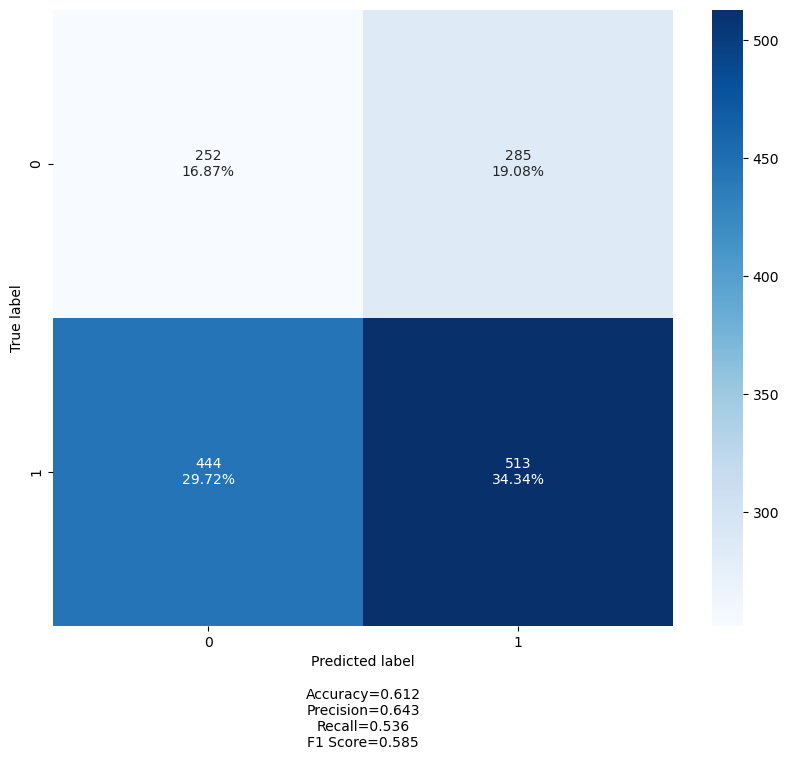

In [66]:
cfm(lower=0.5, upper=0.5)


#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

Profit Saving -> Total PNL : 183.98599859719718%
Without Profit Saving -> Total PNL : 524.6399281022022%


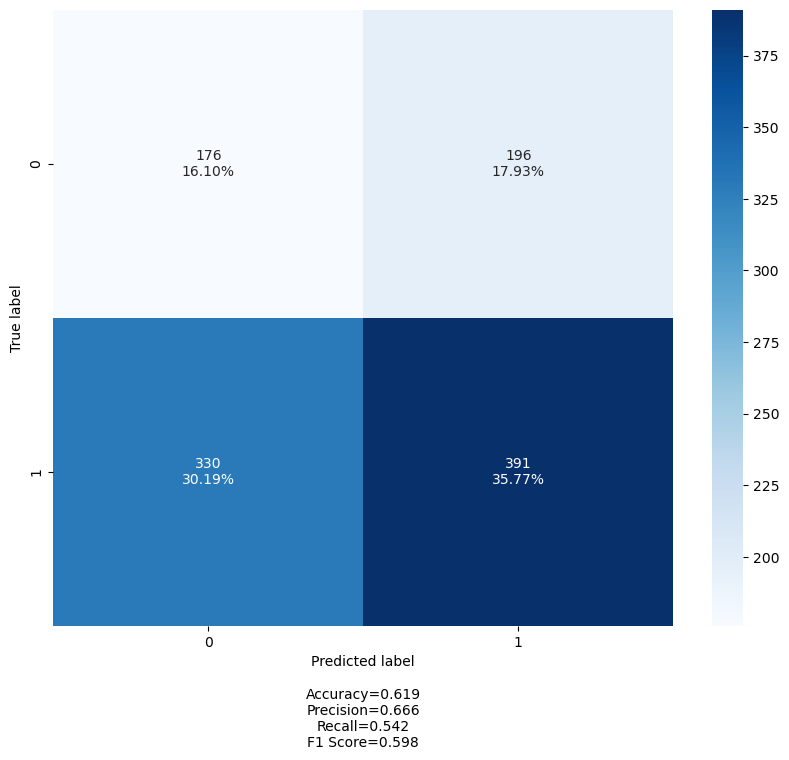

In [67]:
cfm(lower=0.4, upper=0.6)


#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

Profit Saving -> Total PNL : 154.06310114432785%
Without Profit Saving -> Total PNL : 363.41249860581075%


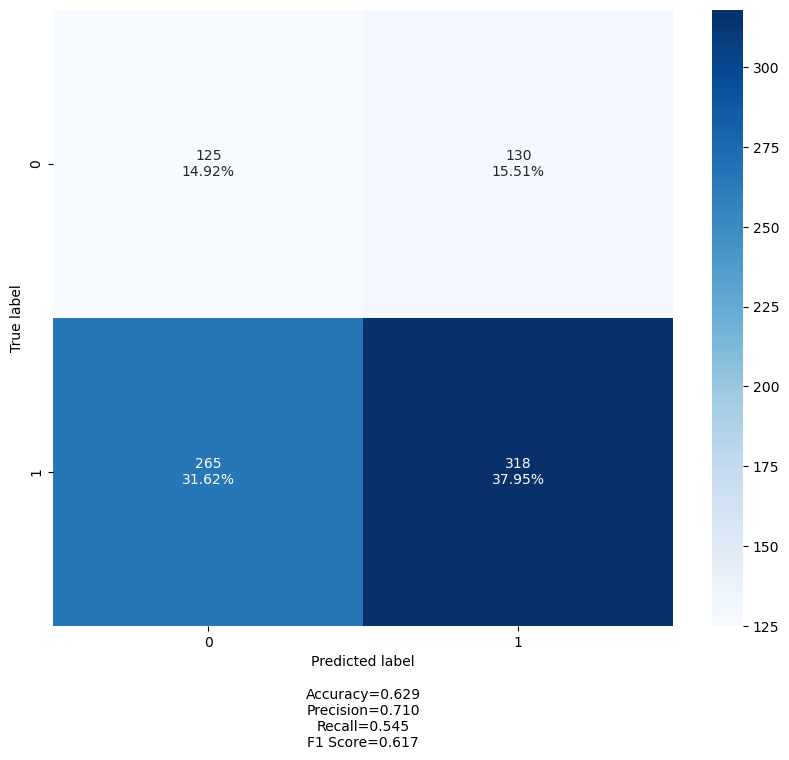

In [68]:
cfm(lower=0.33, upper=0.66)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

Profit Saving -> Total PNL : 109.48997802984479%
Without Profit Saving -> Total PNL : 197.0948562635277%


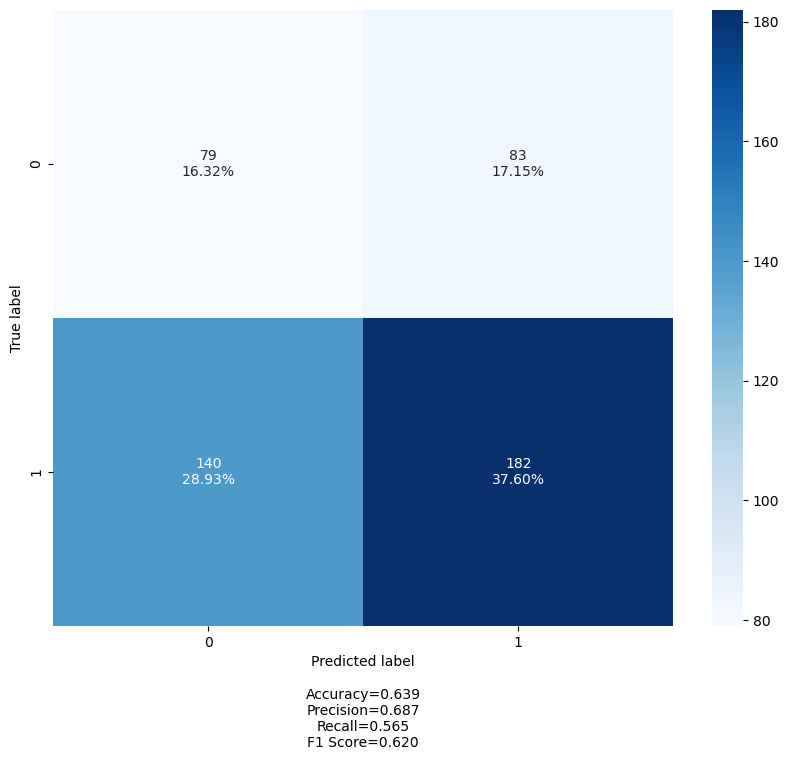

In [69]:
cfm(lower=0.25, upper=0.75)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%")

Profit Saving -> Total PNL : 86.99462646005395%
Without Profit Saving -> Total PNL : 137.4410070873185%


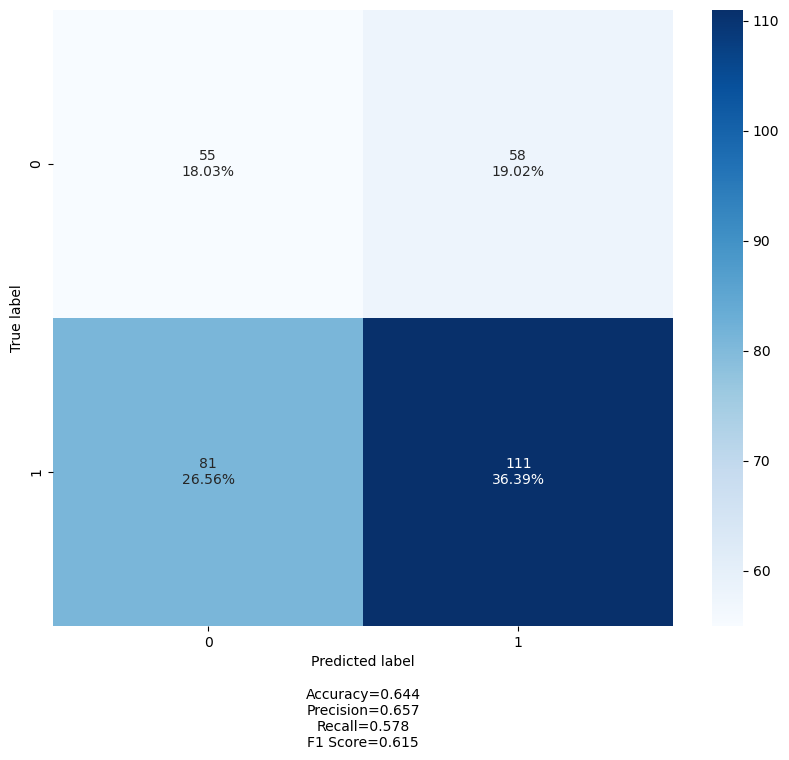

In [70]:
cfm(lower=0.2, upper=0.8)

#profit saving
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * initial_margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Profit Saving -> Total PNL : {pnl}%")


#Use total balance for every positions
initial_margin = 100
margin = initial_margin
for i in range(len(bet_sizing)):

  position_size = bet_sizing[i] * margin
  return_value = clipped_ret[i]
  side = 1 if clipped_y_test[i] == 1.0 else -1

  margin += position_size * return_value * side
pnl = 100*(margin - initial_margin) / initial_margin
print(f"Without Profit Saving -> Total PNL : {pnl}%") 